In [1]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [2]:
!pip install lightGBM

In [3]:
import gc
gc.collect()

214

In [4]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
is_denso = False
train_path = '/home/hayato/horse_inference/data_for_train/train_data/2024/'
if is_denso:
    train_path = '/home/denso/horse_inference/data_for_train/train/2005_2019/train_data_sorted_horse_standard_2005_2019.csv'

# train dataを読み込み
train_data = pd.read_csv(train_path + "train_data_results_2024.csv", encoding='utf-8')
# データが多いと落ちるので半分だけ取得
# train_data = train_data[:int(len(train_data)/2)]
print("train data length {}".format(len(train_data)))

# 勝率データ、過去のデータを取得
horse_past_data = pd.read_csv(train_path + 'horse_results_2024.csv', encoding='utf-8')  
# データが多いと落ちるので半分だけ取得
# horse_past_data = horse_past_data[:int(len(horse_past_data)/2)]  
print("horse_past_data length {}".format(len(horse_past_data)))
horse_peds_data = pd.read_csv(train_path + 'horse_born_results_2024.csv', encoding='utf-8')
# train_data = train_data[:100000]
# horse_peds_data = horse_peds_data[:int(len(horse_peds_data)/2)]
print("horse_peds_data length {}".format(len(horse_peds_data)))
# ジョッキーの過去データを取得
jockey_past_data = pd.read_csv(train_path + 'jockey_results_2024.csv', encoding='utf-8')
# jockeyデータはデータの中で"累計"が含まれているものだけを抽出
# "年度"列が"累計"の行だけを抽出
jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']

train data length 45583
horse_past_data length 139774
horse_peds_data length 11560


In [5]:
# horse_past_dataから最初のhorse_idの情報だけを抽出
first_horse_past_data = horse_past_data.drop_duplicates(subset='horse_id', keep='first')
# train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')

# train dataに対してhorse_past_data、horse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, first_horse_past_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            45583 non-null  object 
 1   枠番            45583 non-null  int64  
 2   馬番            45583 non-null  int64  
 3   馬名            45583 non-null  object 
 4   性齢            45583 non-null  object 
 5   斤量            45583 non-null  float64
 6   騎手_x          45583 non-null  object 
 7   タイム_x         45171 non-null  object 
 8   着差_x          41837 non-null  object 
 9   単勝            45583 non-null  object 
 10  人気            45400 non-null  float64
 11  馬体重_x         45583 non-null  object 
 12  調教師           45583 non-null  object 
 13  course_len    45583 non-null  int64  
 14  weather       45583 non-null  object 
 15  race_type     45583 non-null  object 
 16  ground_state  45583 non-null  object 
 17  date          45583 non-null  object 
 18  horse_id      45583 non-nu

In [6]:
# train_dataに対してjockey_past_dataをjockey_idをキーにして結合
# jockey_resultsから必要なjockey_idの情報だけを抽出
jockey_info = jockey_past_data[jockey_past_data['jockey_id'].isin(train_data['jockey_id'])]

train_data = pd.merge(train_data, jockey_info, on='jockey_id', how='left')
# train_data = pd.merge(train_data, jockey_past_data, on='jockey_id', how='left')
print(train_data.info())
# テスト的にtrain_dataのデータをcsvに保存
train_data.to_csv(train_path + "train_data_check.csv", index=False, encoding='utf-8')
print("train_data lenght :{}".format(len(train_data)))
train_data.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 59 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            45583 non-null  object 
 1   枠番            45583 non-null  int64  
 2   馬番            45583 non-null  int64  
 3   馬名            45583 non-null  object 
 4   性齢            45583 non-null  object 
 5   斤量            45583 non-null  float64
 6   騎手_x          45583 non-null  object 
 7   タイム_x         45171 non-null  object 
 8   着差_x          41837 non-null  object 
 9   単勝            45583 non-null  object 
 10  人気            45400 non-null  float64
 11  馬体重_x         45583 non-null  object 
 12  調教師           45583 non-null  object 
 13  course_len    45583 non-null  int64  
 14  weather       45583 non-null  object 
 15  race_type     45583 non-null  object 
 16  ground_state  45583 non-null  object 
 17  date          45583 non-null  object 
 18  horse_id      45583 non-nu

,枠番,馬番,斤量,人気,course_len,horse_id,jockey_id,R,映 像,頭 数,...,厩舎 ｺﾒﾝﾄ,備考,賞金,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利
count,45583.000000,45583.000000,45583.000000,45400.000000,45583.000000,4.558300e+04,45583.000000,45506.000000,0.0,45576.000000,...,0.0,0.0,15338.000000,45583.000000,45583.000000,45583.000000,45583.000000,45583.000000,45583.000000,45583.000000
mean,4.766119,7.646294,55.757113,7.620815,1655.651668,2.020486e+09,1469.703245,7.333319,NaN,13.913024,...,NaN,NaN,416.574358,575.332712,561.660466,549.030779,5255.593182,6941.617138,315.055372,23.793278
std,2.272328,4.387999,1.803266,4.374613,412.222632,1.304144e+06,1199.770167,3.350493,NaN,2.836055,...,NaN,NaN,1284.884895,713.196082,617.666454,559.915548,4376.217866,6037.650252,400.332892,49.323949
min,1.000000,1.000000,49.000000,1.000000,1000.000000,2.012101e+09,422.000000,1.000000,NaN,0.000000,...,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,3.000000,4.000000,55.000000,4.000000,1400.000000,2.020101e+09,1102.000000,4.000000,NaN,12.000000,...,NaN,NaN,42.000000,95.000000,102.000000,116.000000,1735.000000,2043.000000,27.000000,0.000000
50%,5.000000,7.000000,56.000000,7.000000,1600.000000,2.021102e+09,1161.000000,8.000000,NaN,15.000000,...,NaN,NaN,140.000000,312.000000,344.000000,364.000000,3722.000000,4769.000000,169.000000,8.000000
75%,7.000000,11.000000,57.000000,11.000000,1800.000000,2.021106e+09,1191.000000,10.000000,NaN,16.000000,...,NaN,NaN,450.000000,803.000000,850.000000,928.000000,8699.000000,11232.000000,467.000000,23.000000
max,8.000000,18.000000,65.000000,18.000000,4250.000000,2.022110e+09,5667.000000,12.000000,NaN,23.000000,...,NaN,NaN,50340.200000,4559.000000,3451.000000,2772.000000,18791.000000,24936.000000,2047.000000,363.000000


In [7]:
train_data_for_ranking = train_data.copy()


In [8]:
inference_page_id = 2024060508

inference_data_path = "/home/hayato/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"
if is_denso:
    inference_data_path = "/home/denso/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"

In [9]:
train_data


,着順,枠番,馬番,馬名,性齢,斤量,騎手_x,タイム_x,着差_x,単勝,...,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利,勝率,連対率,複勝率
0,1,5,5,ポッドベイダー,牡2,55.0,佐々木大,1:08.8,NaN,1.2,...,157,136,166,1430,1889,35,3,8.3％,15.5％,24.3％
1,2,2,2,ニシノクードクール,牝2,55.0,武藤雅,1:09.1,1.3/4,10.2,...,189,219,227,3273,3908,78,0,4.8％,10.4％,16.2％
2,3,3,3,ロードヴェルト,牡2,55.0,横山武史,1:09.4,1.3/4,7.9,...,660,555,539,3899,5653,272,23,11.7％,21.5％,31.0％
3,4,1,1,ルージュアマリア,牝2,55.0,永野猛蔵,1:10.0,3.1/2,5.9,...,111,139,130,2121,2501,33,0,4.4％,10.0％,15.2％
4,5,4,4,ロードヴァルカン,牡2,54.0,角田大河,1:10.1,クビ,21.3,...,90,98,110,1295,1593,35,1,5.6％,11.8％,18.7％
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45578,11,4,7,グランデスフィーダ,牡4,58.0,荻野極,1:46.6,2,32.3,...,226,211,239,3347,4023,118,2,5.6％,10.9％,16.8％
45579,12,6,10,アメリカンチーフ,牡3,54.0,西塚洸二,1:46.8,1.1/4,51.0,...,70,64,58,930,1122,9,0,6.2％,11.9％,17.1％
45580,13,5,8,シブースト,牝4,53.0,吉村誠之,1:49.0,大,167.0,...,38,36,43,496,613,4,0,6.2％,12.1％,19.1％
45581,14,8,15,ペイシャコパ,牝3,50.0,河原田菜,1:49.1,3/4,85.7,...,20,27,33,643,723,1,0,2.8％,6.5％,11.1％


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 59 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            45583 non-null  object 
 1   枠番            45583 non-null  int64  
 2   馬番            45583 non-null  int64  
 3   馬名            45583 non-null  object 
 4   性齢            45583 non-null  object 
 5   斤量            45583 non-null  float64
 6   騎手_x          45583 non-null  object 
 7   タイム_x         45171 non-null  object 
 8   着差_x          41837 non-null  object 
 9   単勝            45583 non-null  object 
 10  人気            45400 non-null  float64
 11  馬体重_x         45583 non-null  object 
 12  調教師           45583 non-null  object 
 13  course_len    45583 non-null  int64  
 14  weather       45583 non-null  object 
 15  race_type     45583 non-null  object 
 16  ground_state  45583 non-null  object 
 17  date          45583 non-null  object 
 18  horse_id      45583 non-nu

In [ ]:
# 前処理
def preprocess(train_data, is_ranking=False):
    # 不要な特長量であるUnnamed: 0、class_list_in_raceを削除する
    # train_data = train_data.drop(['馬名','騎手_x', '人気',"調教師","枠番"], axis=1)
    # これはlightGBMによる成約であり、0からクラス数-1の目的変数にラベリングしなければならない

    # 着順はobject型であるため、int型に変換する。"除"、"中"のような文字列だった場合は100に変換する
    train_data['着順'] = train_data['着順'].replace('除', 100).replace('中', 100).replace('取', 100).replace('計不', 100)
    # 着順が計不の場合は100に変換する
    train_data['着順'] = train_data['着順'].replace('計不', 100)
    train_data['着順'] = train_data['着順'].astype(int)
    train_data['goal_number'] = train_data['着順']

    if not is_ranking:
        # ランキング学習でない場合は通常のグルーピング
        # 目的変数であるgoal_numberをグルーピングする。1であれば0、2と3は1にまとめる、4以上は2にまとめる
        train_data['goal_number'] = train_data['goal_number'].replace(
            {1: 0, 2: 1, 3: 1}
        ).apply(lambda x: 2 if x >= 4 else x)
    else:
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        # goal numberをスコア化
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        train_data['goal_number_replace'] = train_data['goal_number'].apply(
            lambda x: 30 if x == 1 else (28 if x == 2 else (26 if x == 3 else 0)))
    
    # inference に合わせて前処理を実施
    # 性齢の1文字から性別を取得しhorse_sexへ、2文字目以降から年齢を取得しhorse_ageへ格納する
    train_data['horse_sex'] = train_data['性齢'].apply(lambda x: x[0])
    train_data['horse_age'] = train_data['性齢'].apply(lambda x: int(x[1:]))
    # 馬体重_xから体重と、()内の増減を取得する
    # 馬体重が計不の場合は500
    train_data['馬体重_x'] = train_data['馬体重_x'].replace('計不', '500(0)')
    train_data['horse_weight'] = train_data['馬体重_x'].apply(lambda x: int(x.split('(')[0]))
    train_data['weight_change'] = train_data['馬体重_x'].apply(lambda x: int(x.split('(')[1].replace(')', '')))
    # 斤量を取得しhandiに格納する
    train_data['handi'] = train_data['斤量'].apply(lambda x: int(x))
    # course_lenを取得しdistanceに格納する
    train_data['distance'] = train_data['course_len'].apply(lambda x: int(x))
    # race_typeを取得し1文字目を取得しconditionに格納する
    train_data['condition'] = train_data['race_type'].apply(lambda x: x[0])
    # 馬番を取得しumabanに格納する
    train_data['umaban'] = train_data['馬番'].apply(lambda x: int(x))
    # 単勝を取得しoddsに格納する
    # 単勝が---の場合は100に変換する
    train_data['単勝'] = train_data['単勝'].replace('---', 100)
    train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))
    # タイム_yは1:34.0のような形式なので、秒に変換する
    # nanの場合は100に変換する
    # 'タイム_y'列の値を文字列に変換し、NaN値を無視して処理を行う
    train_data['タイム_y'] = train_data['タイム_y'].astype(str).apply(
        lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if ':' in x else np.nan
    )

    # 'ペース'列の値を文字列に変換し、NaN値を無視して処理を行う
    train_data['pace1'] = train_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[0]) if '-' in x else np.nan
    )
    train_data['pace2'] = train_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[1]) if '-' in x else np.nan
    )

    # 馬体重_yは480(+2)のような形式なので、体重と増減を分ける
    train_data['馬体重_y'] = train_data['馬体重_y'].replace('計不', '500(0)')
    train_data['horse_weight_y'] = train_data['馬体重_y'].apply(lambda x: int(x.split('(')[0]))
    # 'weight_change_y'列を作成し、'馬体重_y'列の値を処理
    train_data['weight_change_y'] = train_data['馬体重_y'].apply(
        lambda x: int(x.split('(')[1].replace(')', '')) if '(' in x else np.nan
    )

    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['連対率'] = train_data['連対率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['勝率'] = train_data['勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '複勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['複勝率'] = train_data['複勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )
    # columnの名前を確認し、:や 、"、'がある場合は_に置き換える
    # train_data.columns = train_data.columns.str.replace(":", "_")
    # train_data.columns = train_data.columns.str.replace(",", "_")
    # train_data.columns = train_data.columns.str.replace("'", "_")
    # train_data.columns = train_data.columns.str.replace('"', "_")
    # train_data.columns = train_data.columns.str.replace(" ", "_")

    # train dataのカラム情報を表示
    print(train_data.columns)

    # 学習、推論データの特長量を定義する
    target_feature = 'goal_number'
    features = [
        'distance',
        'condition',
        'umaban',
        'horse_age',
        'horse_sex',
        'horse_weight',
        'weight_change',
        'handi',
        'odds',
        # ここまではtrain_resultとinferenceから抽出できる共通データ

        # ここからは馬の過去データから抽出できるので必要な情報を追加する
        '天 気',
        '頭 数',
        '枠番',
        '馬番',
        'オ ッ ズ',
        '人気',
        '着順',
        '斤量',
        '距離',
        '馬 場',
        'タイム_y',
        'pace1',
        'pace2',
        '上り',
        'horse_weight_y',
        'weight_change_y',
        '賞金',
        # ここからはジョッキーの過去データから抽出できるので必要な情報を追加する
        '1着',
        '2着',
        '3着',
        '4着〜',
        '騎乗 回数',
        '重賞 出走',
        '重賞 勝利',
        '勝率',
        '連対率',
        '複勝率',
    ]
    # 特長量を抽出する
    if is_ranking:
        train_data = train_data[features + [target_feature] + ['goal_number_replace']]
    else:
        train_data = train_data[features + [target_feature]]
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = train_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        train_data[column] = le.fit_transform(train_data[column])
    # 学習データが大きすぎるので、train_dataの上から1000行を取得して学習データとする
    # if not is_ranking:
    #     train_data = train_data[:50000]
    print(train_data.info())
    return train_data

train_data = preprocess(train_data)

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', '日付', '開催', '天 気', 'R', 'レース名', '映 像',
       '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y', '斤 量', '距離', '馬 場',
       '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース', '上り', '馬体重_y',
       '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'goal_number',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         45583 non-null  int64  
 1   condition

/tmp/ipykernel_14188/2132262571.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14188/2132262571.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14188/2132262571.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [12]:
train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numbearとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         45583 non-null  int64  
 1   condition        45583 non-null  int64  
 2   umaban           45583 non-null  int64  
 3   horse_age        45583 non-null  int64  
 4   horse_sex        45583 non-null  int64  
 5   horse_weight     45583 non-null  int64  
 6   weight_change    45583 non-null  int64  
 7   handi            45583 non-null  int64  
 8   odds             45583 non-null  float64
 9   天 気              45583 non-null  int64  
 10  頭 数              45576 non-null  float64
 11  枠番               45583 non-null  int64  
 12  馬番               45583 non-null  int64  
 13  オ ッ ズ            45193 non-null  float64
 14  人気               45400 non-null  float64
 15  着順               45583 non-null  int64  
 16  斤量               45583 non-null  float64
 17  距離          

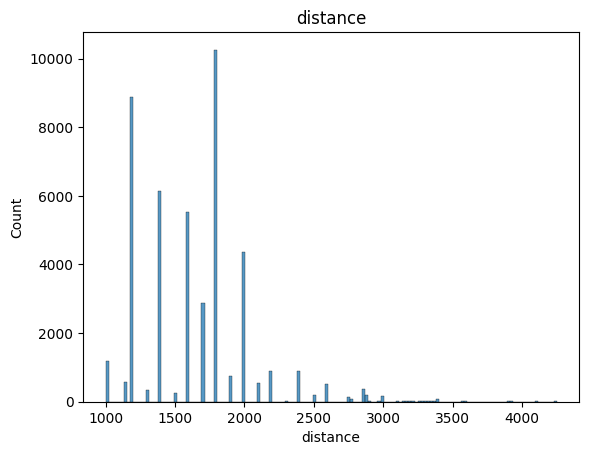

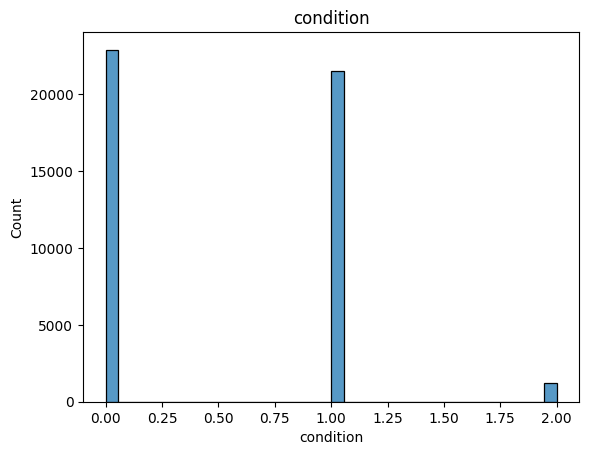

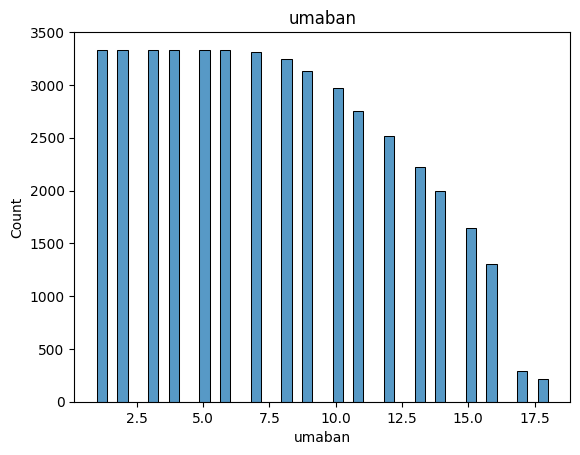

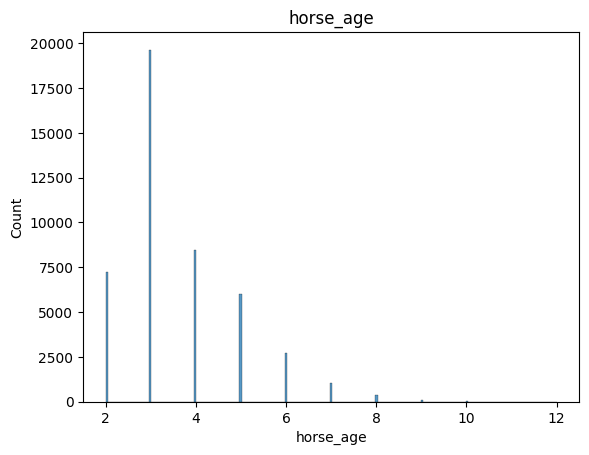

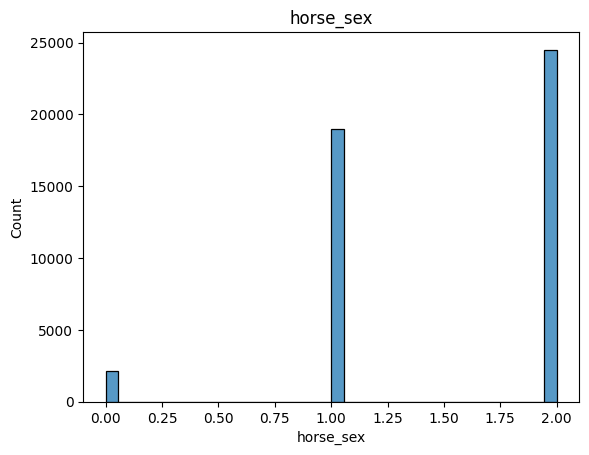

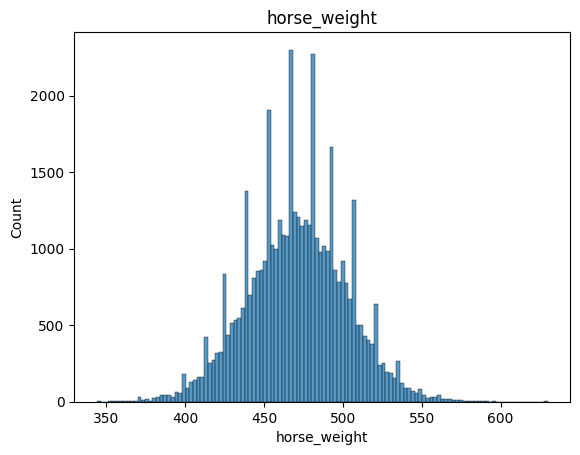

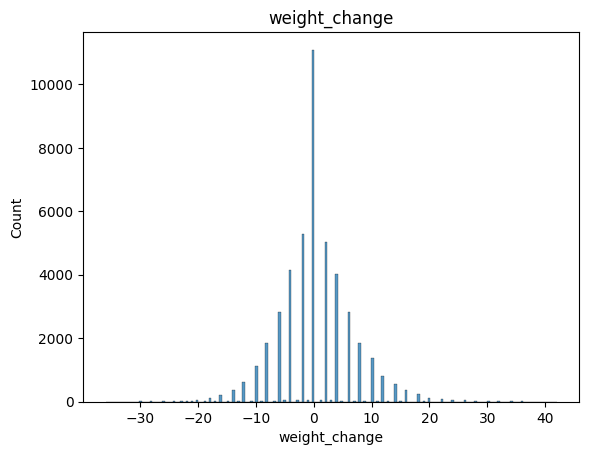

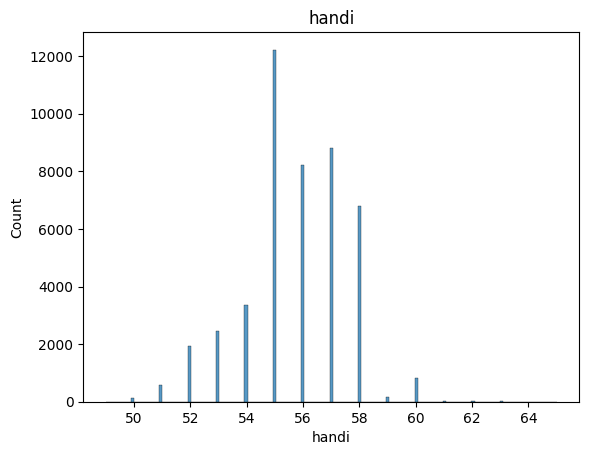

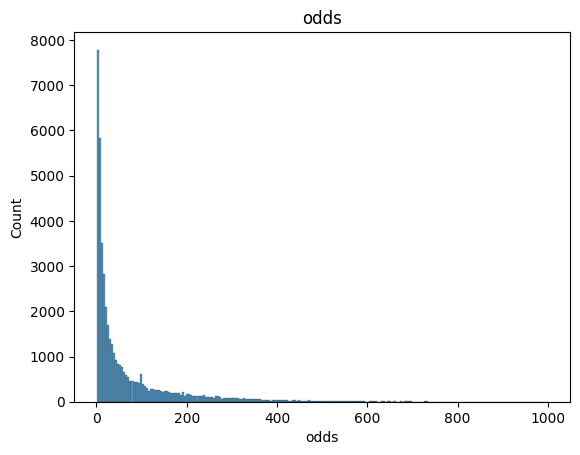

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


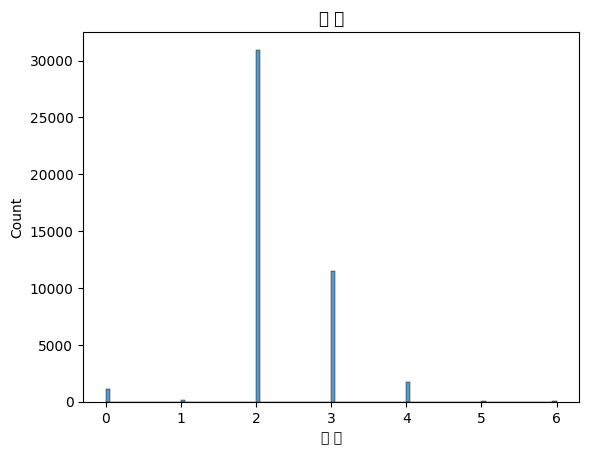

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38957 (\N{CJK UNIFIED IDEOGRAPH-982D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


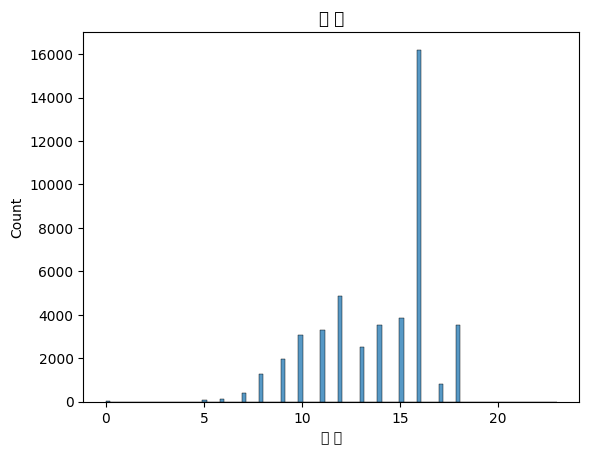

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26528 (\N{CJK UNIFIED IDEOGRAPH-67A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


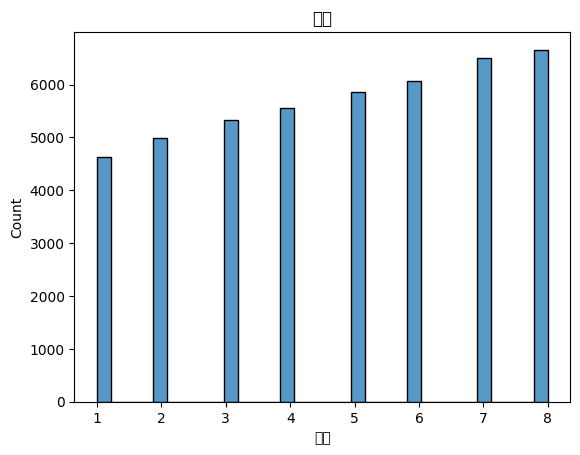

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


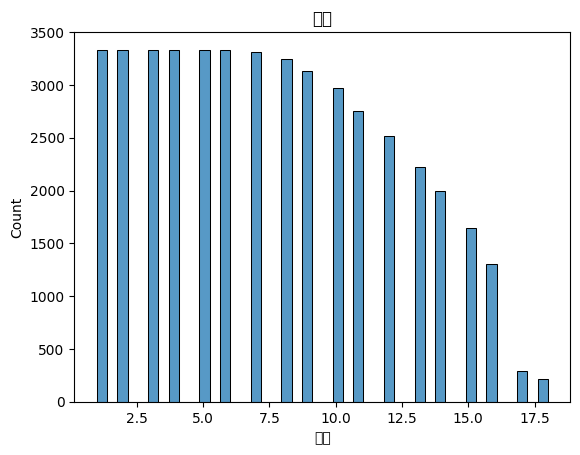

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


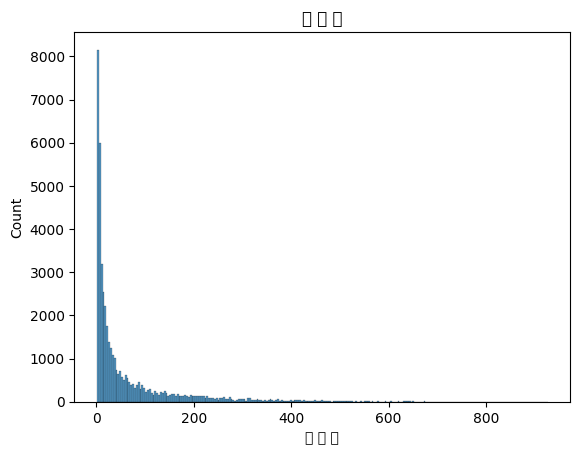

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


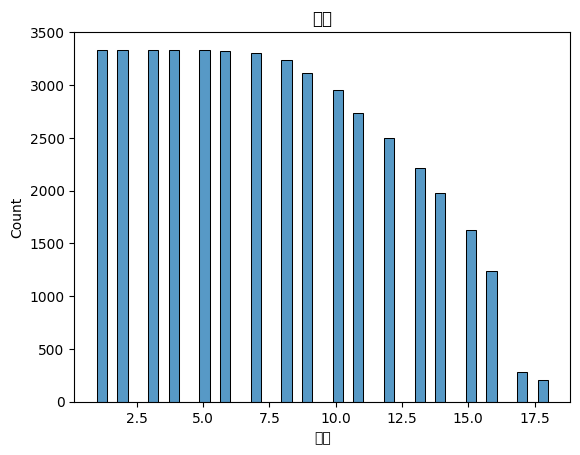

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38918 (\N{CJK UNIFIED IDEOGRAPH-9806}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


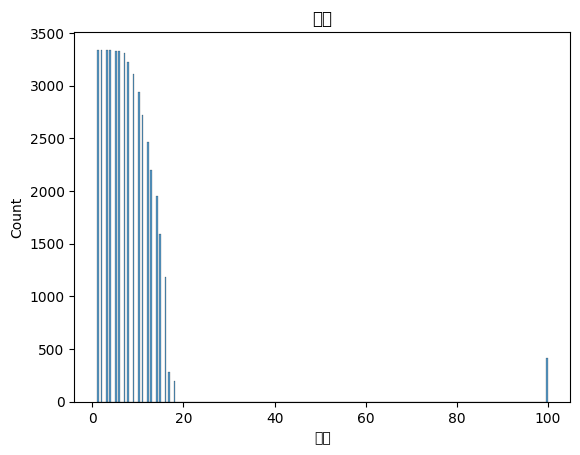

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26020 (\N{CJK UNIFIED IDEOGRAPH-65A4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


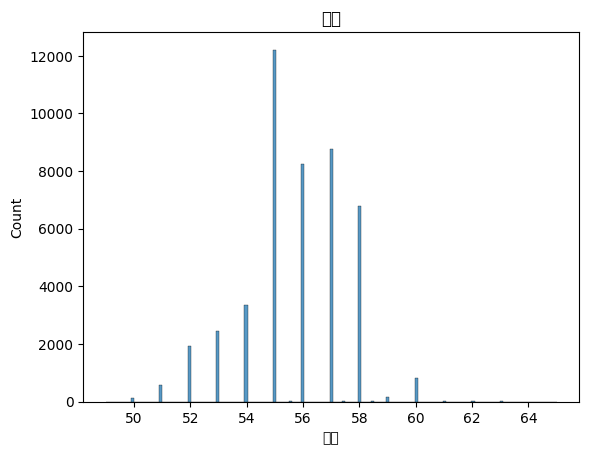

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


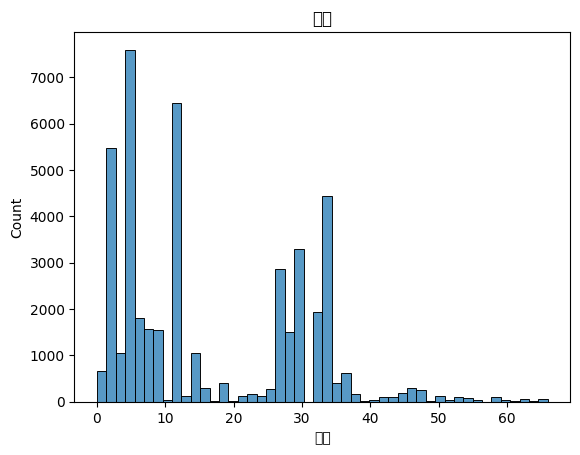

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22580 (\N{CJK UNIFIED IDEOGRAPH-5834}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


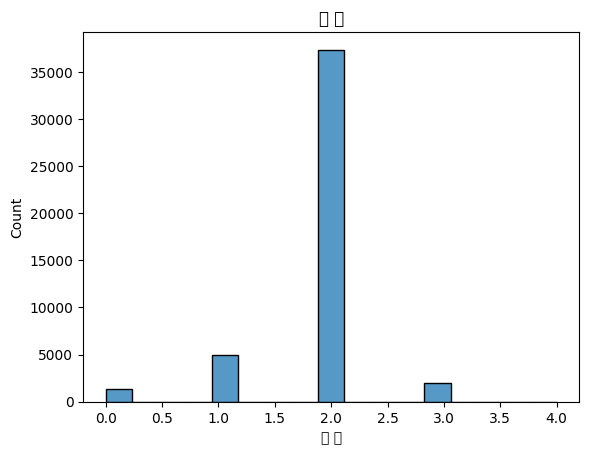

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12512 (\N{KATAKANA LETTER MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


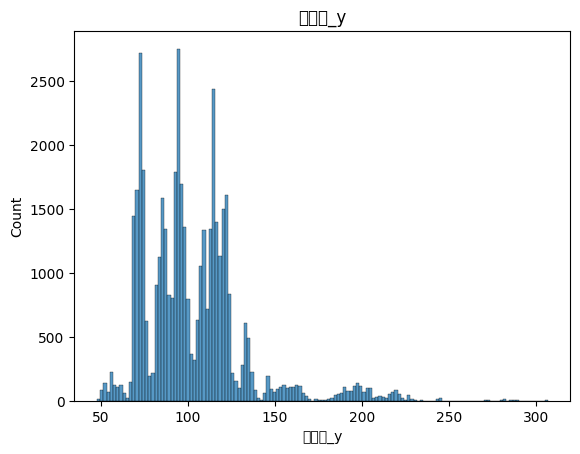

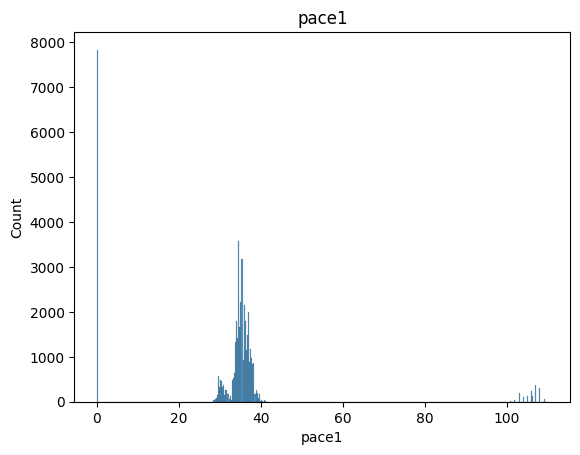

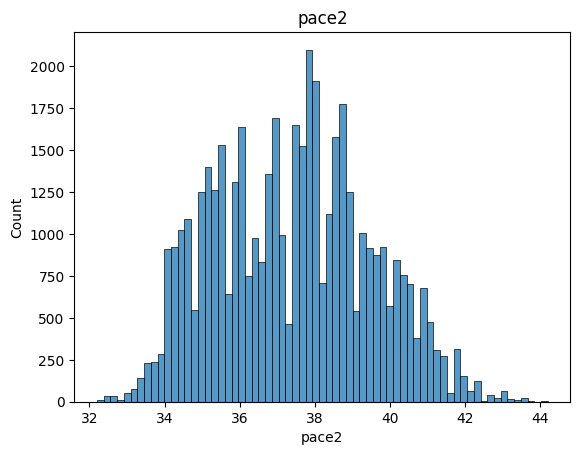

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


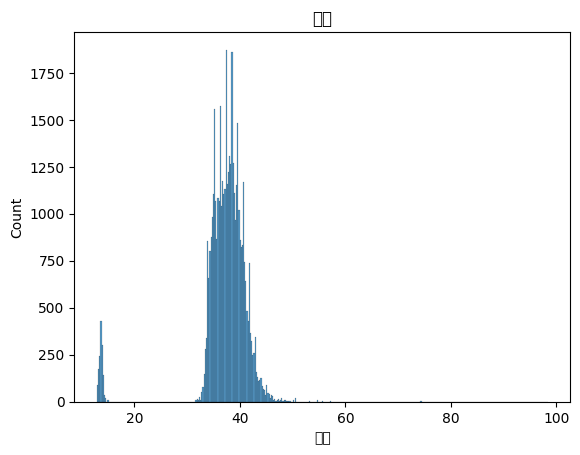

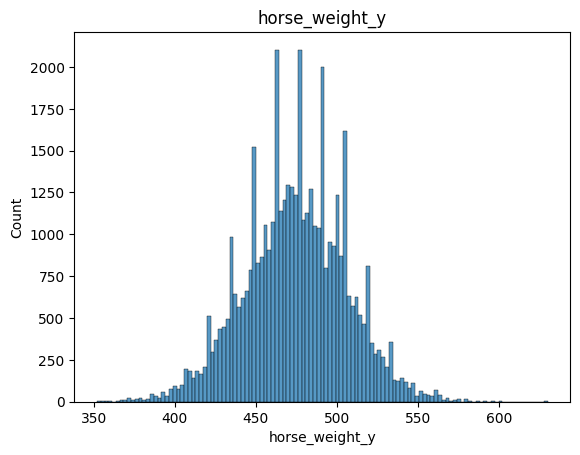

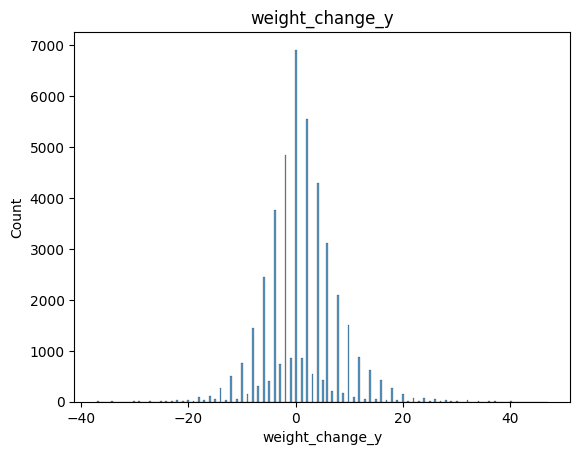

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


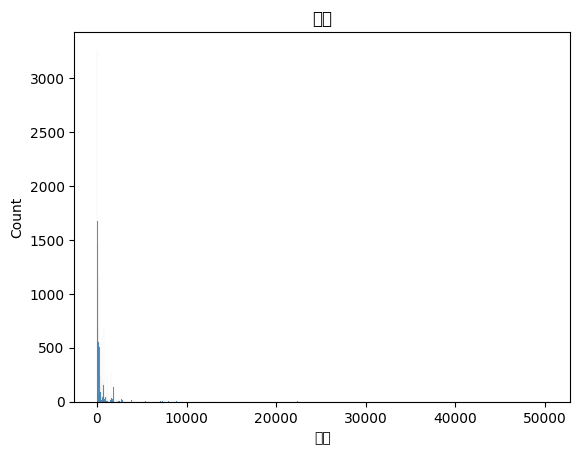

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


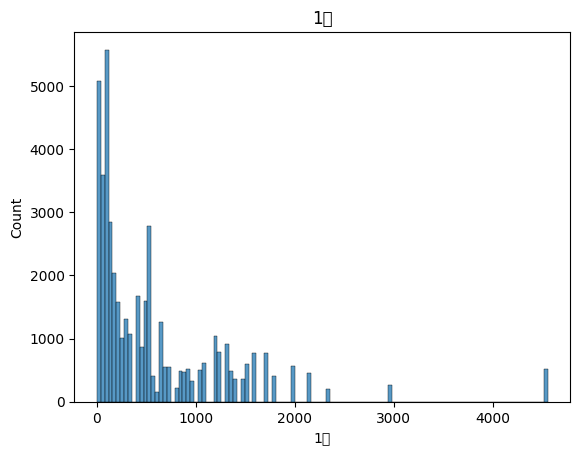

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


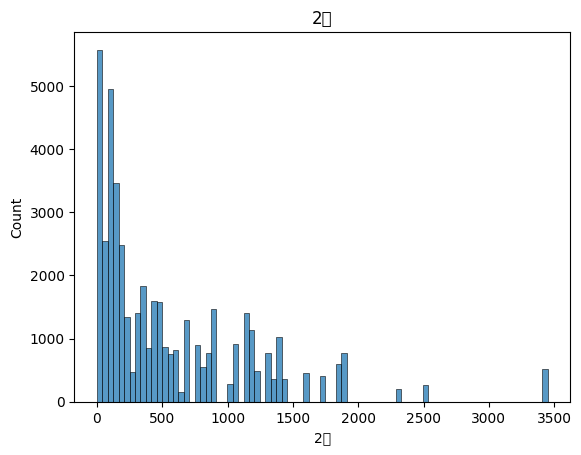

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


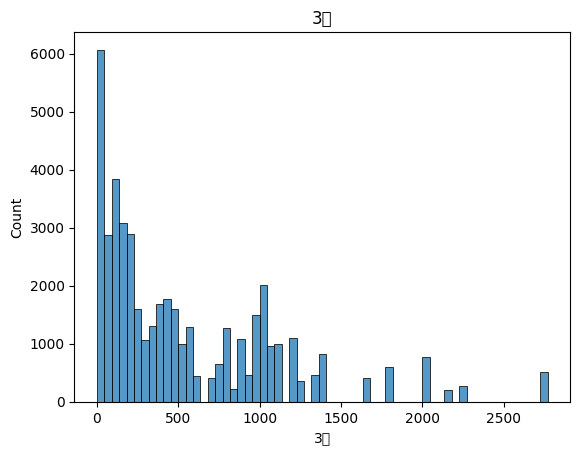

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12316 (\N{WAVE DASH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


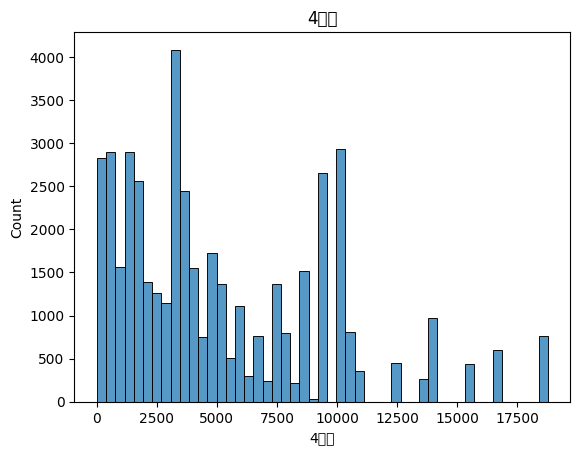

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39438 (\N{CJK UNIFIED IDEOGRAPH-9A0E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20055 (\N{CJK UNIFIED IDEOGRAPH-4E57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


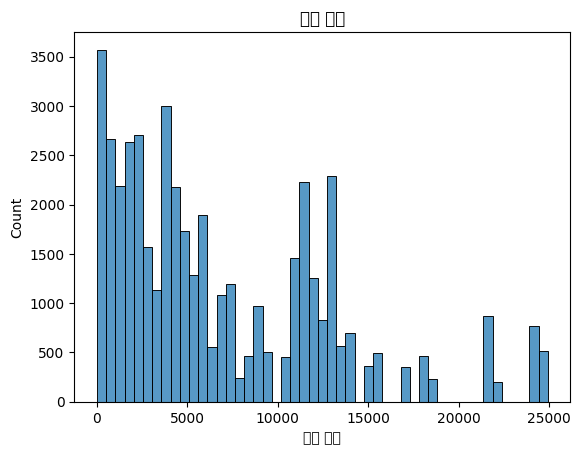

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36208 (\N{CJK UNIFIED IDEOGRAPH-8D70}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


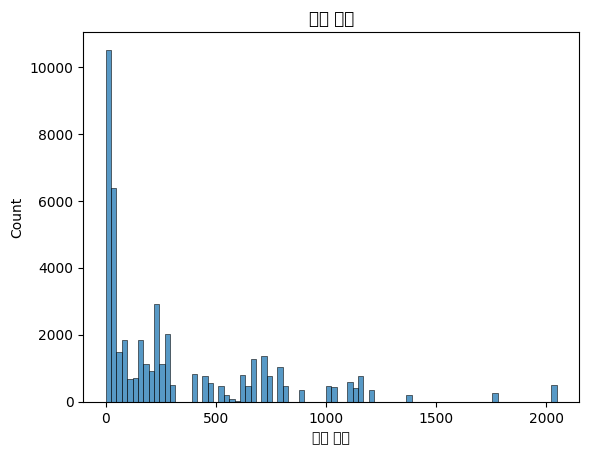

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21033 (\N{CJK UNIFIED IDEOGRAPH-5229}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


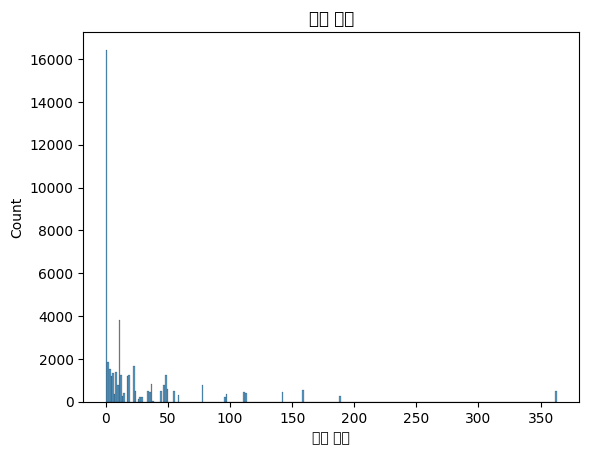

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


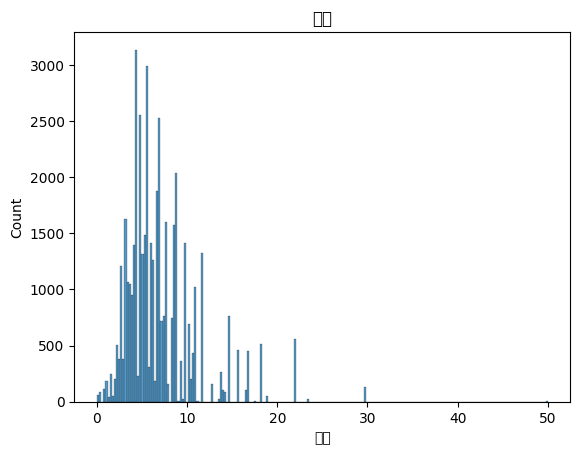

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36899 (\N{CJK UNIFIED IDEOGRAPH-9023}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


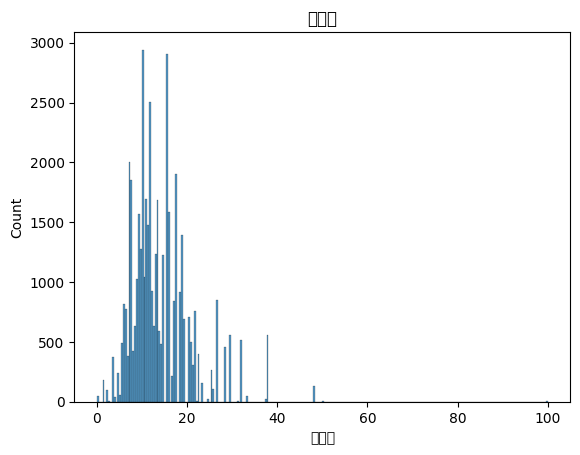

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


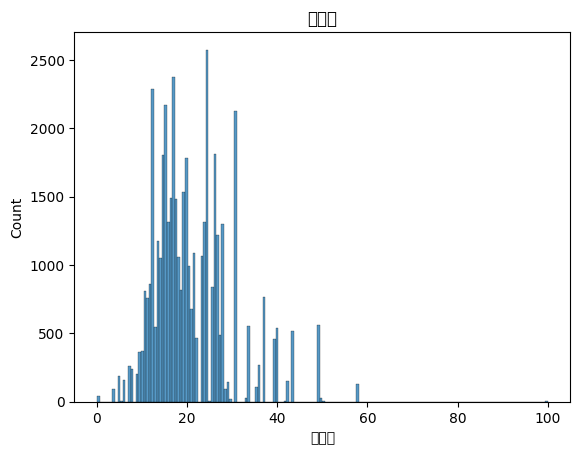

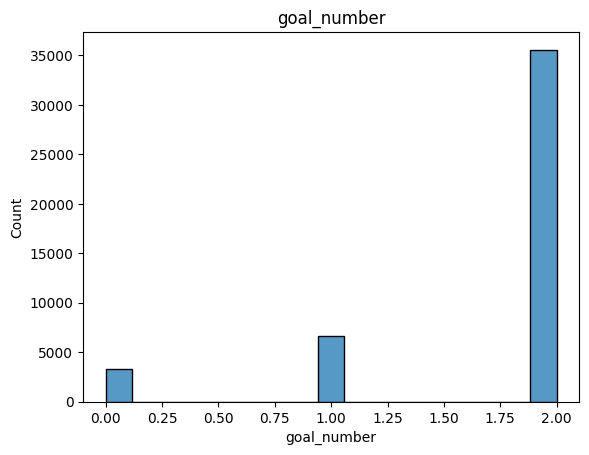

In [13]:
# train_dataの特長量のヒストグラムを表示する
features = train_data.columns
for feature in features:
    plt.figure()
    sns.histplot(train_data[feature])
    plt.title(feature)
    plt.show()


In [14]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [15]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [16]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

train data length 25526
valid data length 6382
test data length 13675
train data length 25526
valid data length 6382
test data length 13675


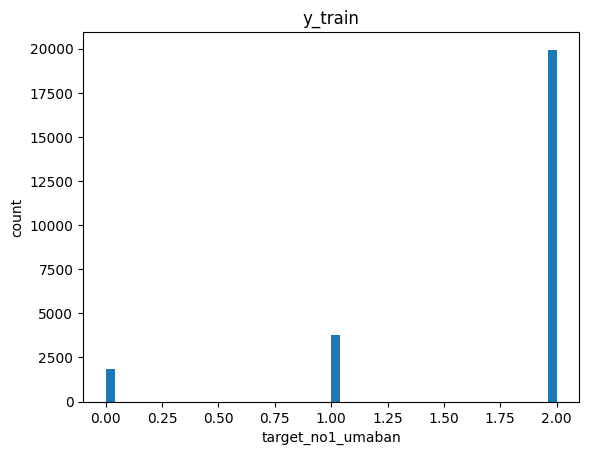

42871    2
34701    2
29495    2
3006     2
30409    2
        ..
10617    1
4999     2
27551    2
34762    2
13201    1
Name: goal_number, Length: 25526, dtype: int64


In [18]:
# 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
print("train data length {}".format(len(X_train)))
print("valid data length {}".format(len(X_valid)))
print("test data length {}".format(len(test_total)))
# 回答データについても、同様にデータ数を表示する
print("train data length {}".format(len(y_train)))
print("valid data length {}".format(len(y_valid)))
print("test data length {}".format(len(y_test_true)))

# 回答データのヒストグラムを表示する
# 横軸をすべての番号で表示する
f, (ax) = plt.subplots()
ax.hist(y_train, bins=50)
ax.set_title('y_train')
ax.set_xlabel('target_no1_umaban')
ax.set_ylabel('count')

plt.show()

print(y_train)


In [19]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[0.42656374 0.42656374 0.42656374 ... 0.42656374 0.42656374 2.2623415 ]
[1. 1. 1. ... 1. 1. 1.]


In [20]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [21]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":100, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [22]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 100,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3440
[LightGBM] [Info] Number of data points in the train set: 25526, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.641961
[LightGBM] [Info] Start training from score -1.915013
[LightGBM] [Info] Start training from score -0.246619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

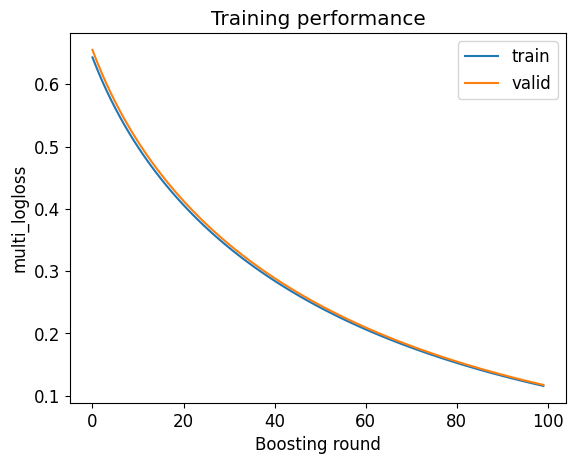

In [23]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [24]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

          0         1         2
0  0.019935  0.039915  0.940150
1  0.019935  0.039915  0.940150
2  0.019935  0.039915  0.940150
3  0.019935  0.039915  0.940150
4  0.036243  0.750975  0.212782
0       0.019935
1       0.019935
2       0.019935
3       0.019935
4       0.036243
          ...   
6377    0.019935
6378    0.036243
6379    0.019935
6380    0.019935
6381    0.019935
Name: 0, Length: 6382, dtype: float64


In [25]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0       2
1       2
2       2
3       2
4       1
       ..
6377    2
6378    1
6379    2
6380    2
6381    2
Length: 6382, dtype: int64

In [26]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

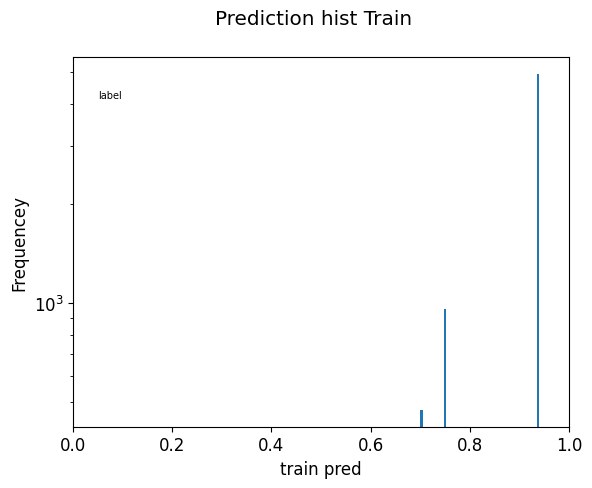

In [27]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [28]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26528 (\N{CJK UNIFIED IDEOGRAPH-67A0}) missing from current font.
  fig.c

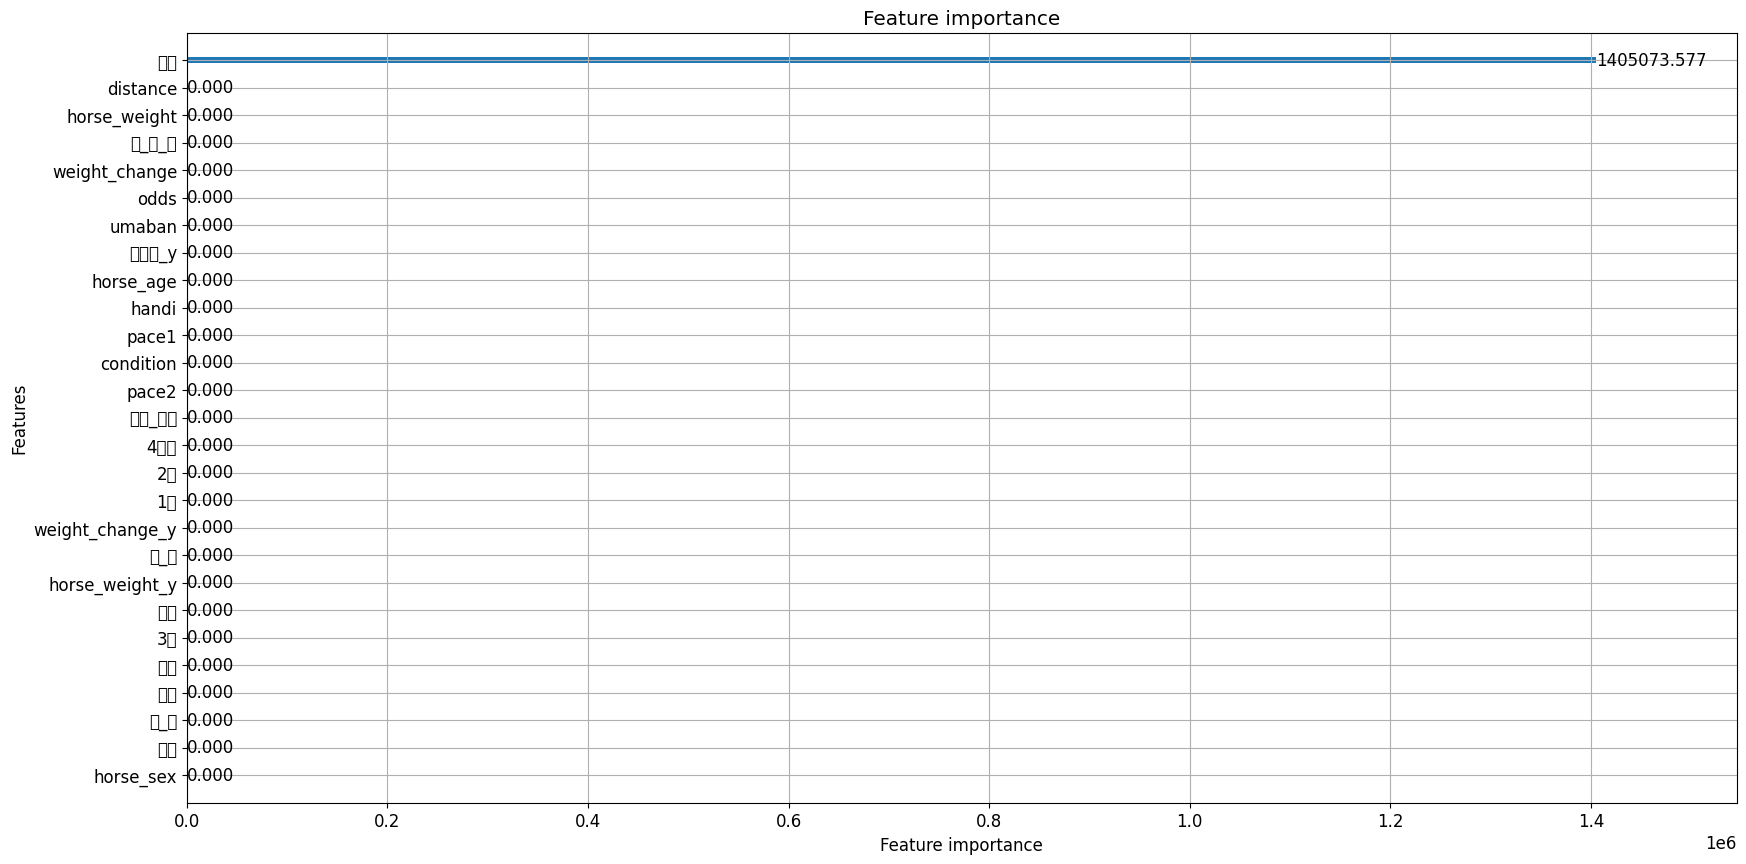

In [29]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=1.0


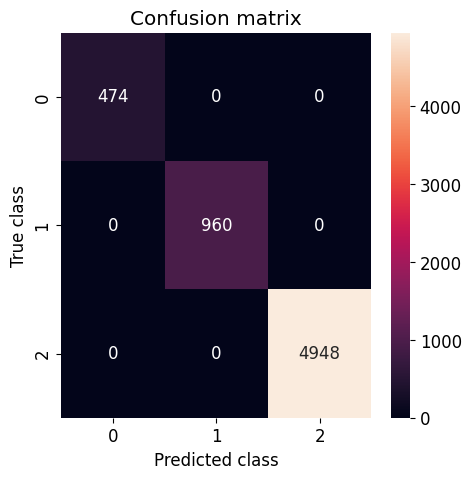

In [30]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=1.0


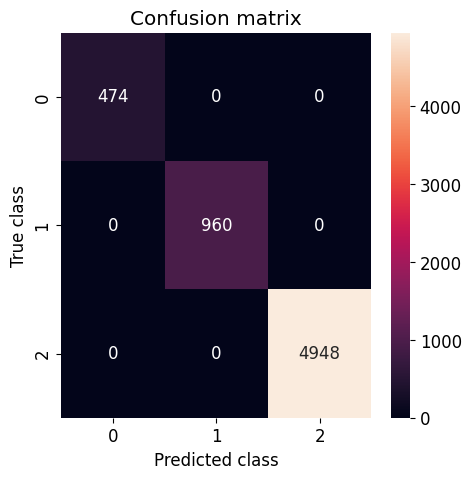

In [31]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


inference test data and compare with test correct data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1048
           1       1.00      1.00      1.00      1950
           2       1.00      1.00      1.00     10677

    accuracy                           1.00     13675
   macro avg       1.00      1.00      1.00     13675
weighted avg       1.00      1.00      1.00     13675



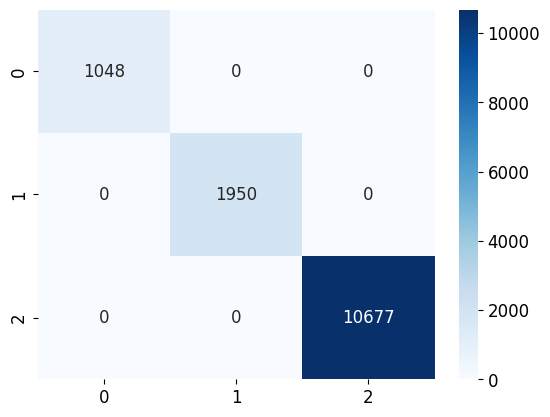

In [32]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

# precisionが正解率。0と1のprecisionが高いと使い物になってくる。なぜなら高い順位の馬を推論できているから

In [33]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_data_for_ranking[:int(len(train_data_for_ranking)*0.7)]
test_ranking = train_data_for_ranking[int(len(train_data_for_ranking)*0.7):]
# train_rankingを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_ranking[:int(len(train_ranking)*0.7)]
valid_ranking = train_ranking[int(len(train_ranking)*0.7):]

def create_query(df, name='train'):
    # データの先頭を表示して確認
    # print("DataFrame head:")
    # print(df.head())

    # date, race_name, place, number_of_horses, distanceのユニークな組み合わせを表示して確認
    print("\nUnique combinations of date, race_name, place, number_of_horses, distance:")
    print(df[['course_len', 'weather', 'race_type', 'ground_state', 'date']].drop_duplicates().head())

    # groupbyを使用してdate, race_name, place, number_of_horses, distanceごとにカウント
    race_place_counts = df.groupby(['course_len', 'weather', 'race_type', 'ground_state', 'date']).size().reset_index(name='horse_count')

    # date列を昇順にソート
    # race_place_counts = race_place_counts.sort_values(by='date', ascending=False)

    # 各レースの馬の数をリストに保存
    horse_counts_list = race_place_counts['horse_count'].tolist()

    # 結果の表示
    print("\nResulting list of horse counts per race (sorted by date):")
    print(horse_counts_list)

    # 特徴量データを日付の古い順にソート
    sorted_df = df.set_index(['course_len', 'weather', 'race_type', 'ground_state', 'date']).sort_index(level='date', ascending=True).reset_index()

    # ソートデータの保存
    # sorted_df.to_csv("sorted_{}_data.csv".format(name), index=False)
    return horse_counts_list, sorted_df

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")





Unique combinations of date, race_name, place, number_of_horses, distance:
    course_len weather race_type ground_state        date
0         1200       晴         芝            良  2024年7月20日
5         1000       晴       ダート            良  2024年7月20日
17        1700       晴       ダート            良  2024年7月20日
31        1500       晴         芝            良  2024年7月20日
59        1800       晴         芝            良  2024年7月20日

Resulting list of horse counts per race (sorted by date):
[10, 23, 32, 23, 23, 12, 12, 12, 16, 12, 12, 24, 11, 18, 17, 18, 12, 17, 18, 12, 16, 16, 12, 16, 16, 16, 16, 16, 11, 18, 17, 18, 18, 17, 12, 23, 12, 12, 12, 12, 10, 24, 12, 12, 12, 12, 12, 14, 18, 18, 11, 10, 12, 16, 29, 16, 16, 16, 16, 29, 48, 32, 31, 32, 25, 16, 48, 32, 11, 8, 16, 16, 16, 16, 16, 13, 16, 16, 16, 15, 32, 12, 10, 16, 16, 16, 15, 30, 43, 16, 28, 14, 48, 48, 32, 32, 48, 27, 21, 36, 39, 30, 32, 14, 32, 32, 16, 64, 15, 36, 44, 14, 30, 45, 44, 13, 14, 30, 30, 30, 44, 30, 15, 15, 15, 15, 16, 32, 48, 3

In [34]:
# クエリの数の合計とデータ数が一致しているか確認
print("Number of queries in train data: {}".format(len(train_query)))
print("Number of queries in valid data: {}".format(len(valid_query)))
print("Total number of queries: {}".format(len(train_query) + len(valid_query)))
print("Number of rows in train data: {}".format(len(sorted_train_data)))
print("Number of rows in valid data: {}".format(len(sorted_valid_data)))
print("Total number of rows: {}".format(len(sorted_train_data) + len(sorted_valid_data)))


Number of queries in train data: 987
Number of queries in valid data: 309
Total number of queries: 1296
Number of rows in train data: 22335
Number of rows in valid data: 6701
Total number of rows: 29036


In [35]:
# クエリを取得したので前処理をかける
X_sorted_train_data = preprocess(sorted_train_data,is_ranking=True)
X_sorted_valid_data = preprocess(sorted_valid_data,is_ranking=True)
test_ranking = preprocess(test_ranking,is_ranking=True)

Index(['course_len', 'weather', 'race_type', 'ground_state', 'date', '着順',
       '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'horse_id', 'jockey_id', '日付', '開催', '天 気', 'R', 'レース名',
       '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y', '斤 量', '距離',
       '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース', '上り', '馬体重_y',
       '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'goal_number',
       'goal_number_replace', 'horse_sex', 'horse_age', 'horse_weight',
       'weight_change', 'handi', 'distance', 'condition', 'umaban', 'odds',
       'pace1', 'pace2', 'horse_weight_y', 'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22335 entries, 0 to 22334
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         22335 non-null 

/tmp/ipykernel_14188/2132262571.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14188/2132262571.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14188/2132262571.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [36]:
# うまく目的変数の変換ができないので、現状のデータを見てみる
# X_sorted_train_data.to_csv("X_sorted_train_data.csv", index=False)

In [37]:
# X_sorted_train_dataにgoal_number_replaceを追加してcsvに保存する
# X_sorted_train_data.to_csv("X_sorted_train_data_add_goal_number.csv", index=False)

In [38]:
# # goal numberをスコア化
# # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([1], 30)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([2], 28)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([3], 26)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 0)

In [39]:
# # goal numberをスコア化
# # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([1], 30)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([2], 28)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([3], 26)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 0)

In [40]:
# 1. 目的変数goal_number_replaceを確保
# 2. 実際のgoal_numberを確保
# 3. goal_number_replaceを削除
# 4. goal_numberを削除
# 1========================================================
y_train_ranking = X_sorted_train_data['goal_number_replace']
y_valid_ranking = X_sorted_valid_data['goal_number_replace']
y_test_true_ranking = test_ranking['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data['goal_number']
y_valid_ranking_goal = X_sorted_valid_data['goal_number']
y_test_true_ranking_goal = test_ranking['goal_number']
# 3========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number', axis=1)
test_ranking = test_ranking.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number_replace', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number_replace', axis=1)
test_ranking = test_ranking.drop('goal_number_replace', axis=1)


KeyError: 'goal_number_replace'

In [38]:
# 学習データ
X_sorted_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_name         49000 non-null  int64  
 1   place             49000 non-null  int64  
 2   number_of_horses  49000 non-null  int64  
 3   distance          49000 non-null  int64  
 4   condition         49000 non-null  int64  
 5   horse_name_       49000 non-null  int64  
 6   umaban            49000 non-null  int64  
 7   horse_age         49000 non-null  int64  
 8   horse_sex         49000 non-null  int64  
 9   horse_weight      49000 non-null  int64  
 10  weight_change     49000 non-null  int64  
 11  handi             49000 non-null  float64
 12  jocky             49000 non-null  int64  
 13  odds              49000 non-null  float64
dtypes: float64(2), int64(12)
memory usage: 5.2 MB


In [39]:
# 検証データ
X_sorted_valid_data.describe()

,race_name,place,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds
count,14700.000000,14700.000000,14700.000000,14700.000000,14700.00000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000,14700.000000
mean,55.058231,44.673878,14.205850,1623.624490,0.57551,2789.507687,7.604082,3.580408,0.411429,467.054354,0.152585,55.123333,111.671769,68.913633
std,89.279711,26.108242,2.522328,458.346716,0.57567,1601.494706,4.342235,1.330688,0.549334,39.027871,6.730083,1.781329,55.468604,100.419558
min,0.000000,0.000000,5.000000,1000.000000,0.00000,0.000000,1.000000,2.000000,0.000000,-22.000000,-34.000000,48.000000,0.000000,1.000000
25%,6.000000,22.000000,12.000000,1200.000000,0.00000,1398.000000,4.000000,3.000000,0.000000,448.000000,-4.000000,54.000000,68.000000,8.600000
50%,8.000000,44.000000,15.000000,1600.000000,1.00000,2772.500000,7.000000,3.000000,0.000000,468.000000,0.000000,55.000000,115.000000,26.600000
75%,63.000000,67.000000,16.000000,1800.000000,1.00000,4211.250000,11.000000,4.000000,1.000000,488.000000,4.000000,56.000000,164.000000,86.600000
max,300.000000,89.000000,18.000000,3930.000000,2.00000,5555.000000,18.000000,11.000000,2.000000,570.000000,48.000000,64.000000,207.000000,922.300000


In [40]:
# 学習データの答え
print(y_train_ranking.head())
y_train_ranking.describe()

0    30
1    26
2     0
3     0
4     0
Name: goal_number_replace, dtype: int64


count    49000.000000
mean         6.029143
std         11.534399
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: goal_number_replace, dtype: float64

In [41]:
print(y_train_ranking_goal.head())
y_train_ranking_goal.describe()

0    1
1    3
2    4
3    8
4    5
Name: goal_number, dtype: int64


count    49000.000000
mean         7.704694
std          4.371639
min          1.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         18.000000
Name: goal_number, dtype: float64

In [42]:
# 検証データの答え
print(y_valid_ranking.head())
y_valid_ranking.describe()

0    28
1     0
2     0
3    30
4     0
Name: goal_number_replace, dtype: int64


count    14700.000000
mean         6.138912
std         11.610056
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: goal_number_replace, dtype: float64

In [43]:
# テストデータ
test_ranking.describe()

,race_name,place,number_of_horses,distance,condition,horse_name_,umaban,horse_age,horse_sex,horse_weight,weight_change,handi,jocky,odds
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,100.182567,88.916767,14.579100,1629.280333,0.540200,4747.086567,7.789800,3.676033,0.413200,468.930833,-0.035500,55.159483,134.582767,71.245257
std,172.975761,51.729402,2.266035,463.498277,0.572999,2726.431278,4.397756,1.350138,0.552578,38.045879,6.807123,1.788229,63.866769,103.623633
min,0.000000,0.000000,6.000000,1000.000000,0.000000,0.000000,1.000000,2.000000,0.000000,-22.000000,-46.000000,48.000000,0.000000,1.100000
25%,6.000000,44.000000,13.000000,1200.000000,0.000000,2371.000000,4.000000,3.000000,0.000000,450.000000,-4.000000,54.000000,80.000000,8.700000
50%,8.000000,90.000000,15.000000,1700.000000,1.000000,4777.000000,8.000000,3.000000,0.000000,470.000000,0.000000,55.000000,137.000000,27.300000
75%,108.000000,134.000000,16.000000,1800.000000,1.000000,7133.250000,11.000000,4.000000,1.000000,490.000000,4.000000,56.000000,193.000000,87.900000
max,580.000000,177.000000,18.000000,4250.000000,2.000000,9487.000000,18.000000,12.000000,2.000000,608.000000,50.000000,63.500000,245.000000,999.900000


In [44]:
# テストデータの答え
print(y_test_true_ranking.head())
y_test_true_ranking.describe()

70000     0
70001     0
70002     0
70003     0
70004    26
Name: goal_number_replace, dtype: int64


count    30000.000000
mean         5.934067
std         11.467713
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: goal_number_replace, dtype: float64

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.metrics import ndcg_score

# データの準備
# X_sorted_train_data, y_train_ranking, train_query
# X_sorted_valid_data, y_valid_ranking, valid_query

# ハイパーパラメータのグリッドを定義
param_grid = {
    'n_estimators': [1000, 5000, 10000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [3,5,12, 31, 50],
    'max_depth': [3,6, 8, 10],
    'min_data_in_leaf': [5,10, 20, 30]
}

# カスタムスコア関数を定義
def ndcg_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return ndcg_score([y], [y_pred], k=5)

# 交差検証の設定
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCVを使用してハイパーパラメータチューニング
model = lgb.LGBMRanker(
    random_state=42,
    objective='lambdarank',
    metric='ndcg'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=ndcg_scorer,
    cv=kf,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query
)
# 最適なパラメータを出力
print("Best parameters found: ", grid_search.best_params_)

# 最適なモデルで再トレーニング
best_model = grid_search.best_estimator_

best_model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 3, 5],
    eval_metric='ndcg',
    early_stopping_rounds=100
)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


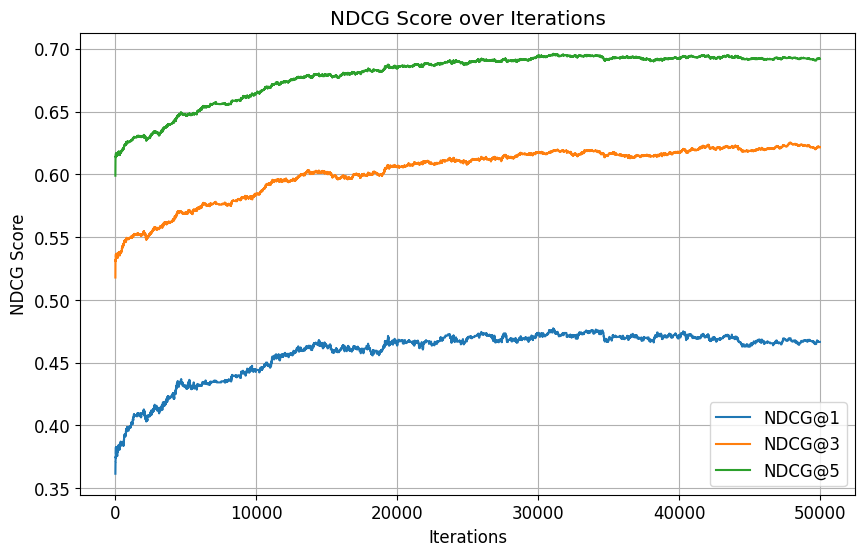

In [45]:
# トレーニング結果の取得
evals_result = best_model.evals_result_

# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evals_result['valid_0']['ndcg@3'], label='NDCG@3')
plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
#　テストデータで推論

prediction_test_ranking = best_model.predict(test_ranking, num_iteration=best_model.best_iteration_)

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking["umaban"],
    "予測スコア": prediction_test_ranking,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
})
print(df_prediction_test_ranking)
# pandasをcsvに保存
inference_data_path_result = inference_data_path + "inference_result/"
if not os.path.isdir(inference_data_path_result):
    os.mkdir(inference_data_path_result)
df_prediction_test_ranking.to_csv(inference_data_path_result + "prediction_test_ranking.csv", index=False)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
       馬番号     予測スコア  着順関連度  着順
70000    8 -7.494930      0  10
70001    9 -0.150686      0   4
70002   10 -1.493907      0   5
70003   11 -4.113807      0  12
70004   12 -0.523346     26   3
...    ...       ...    ...  ..
99995    6  0.217828      0   7
99996    7  0.145389      0   5
99997    8 -2.786646      0   6
99998    9  0.114440     26   3
99999   10 -5.079445      0   8

[30000 rows x 4 columns]


In [47]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data.columns, "importance": best_model.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

             columns  importance
13              odds       83611
5        horse_name_       70800
1              place       70664
12             jocky       59655
9       horse_weight       59447
6             umaban       38667
0          race_name       37718
10     weight_change       35327
3           distance       26328
2   number_of_horses       24866
11             handi       19643
7          horse_age       11825
8          horse_sex        5977
4          condition        5472


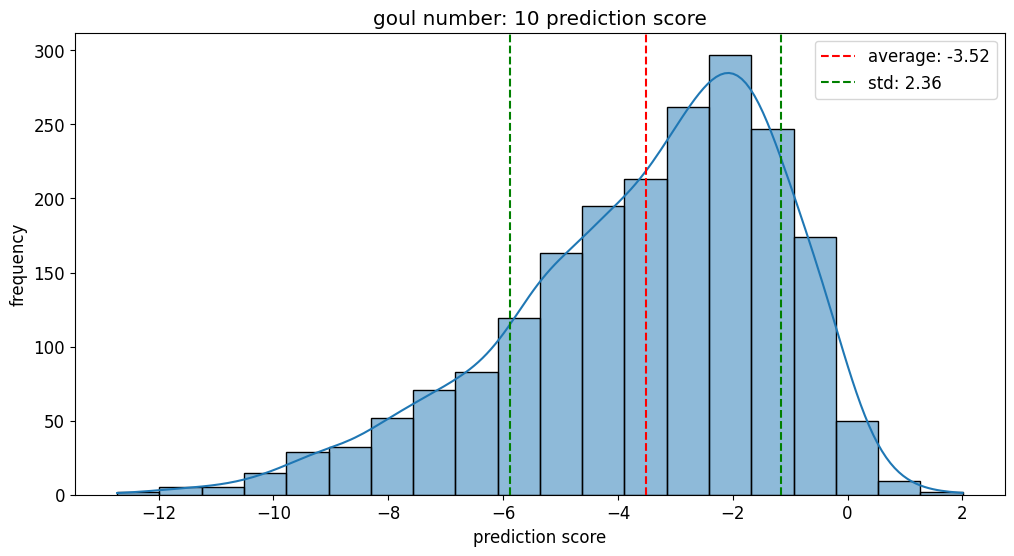

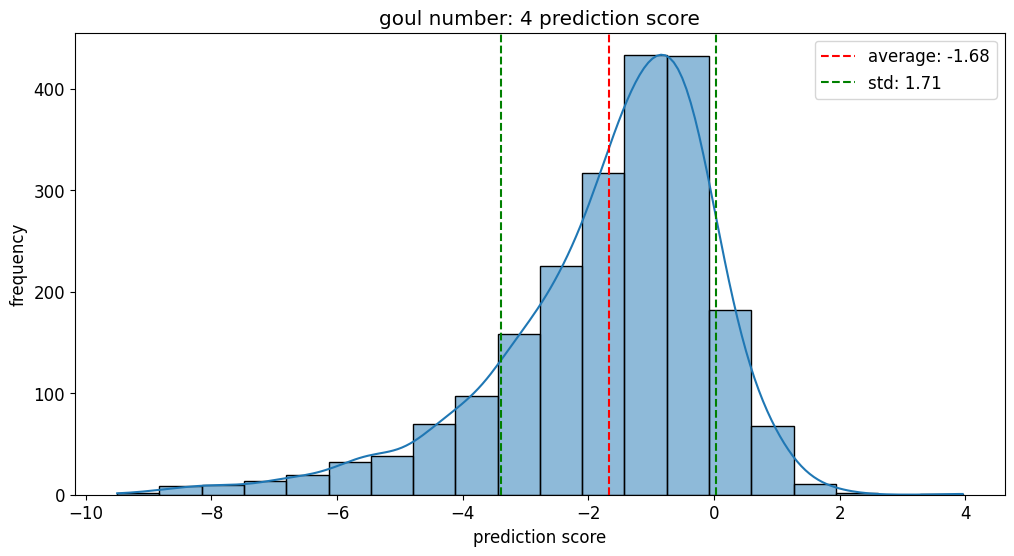

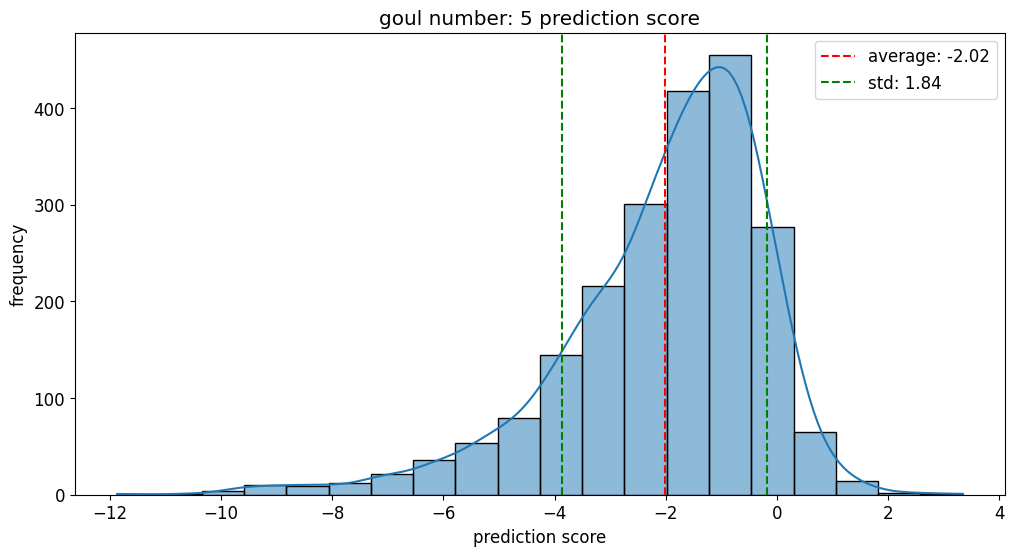

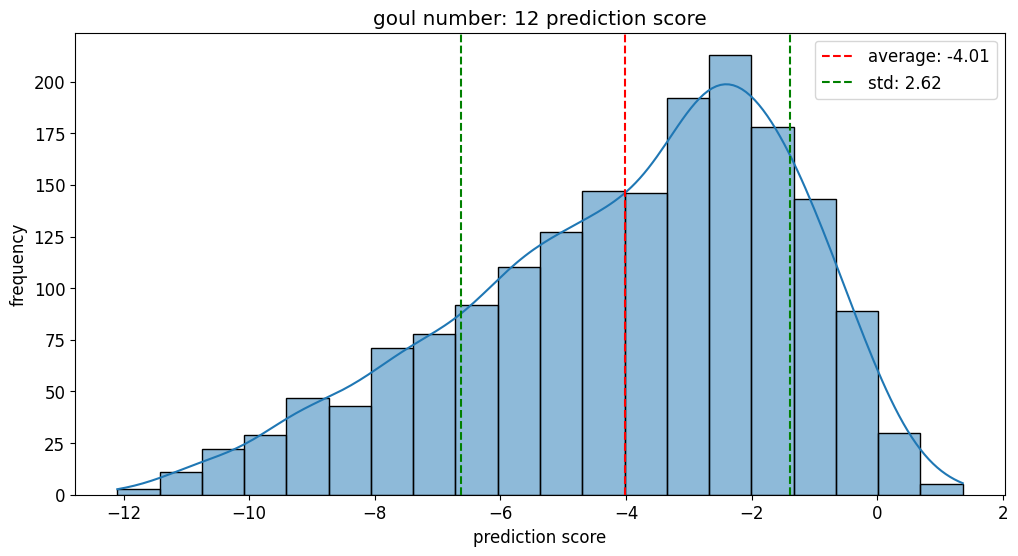

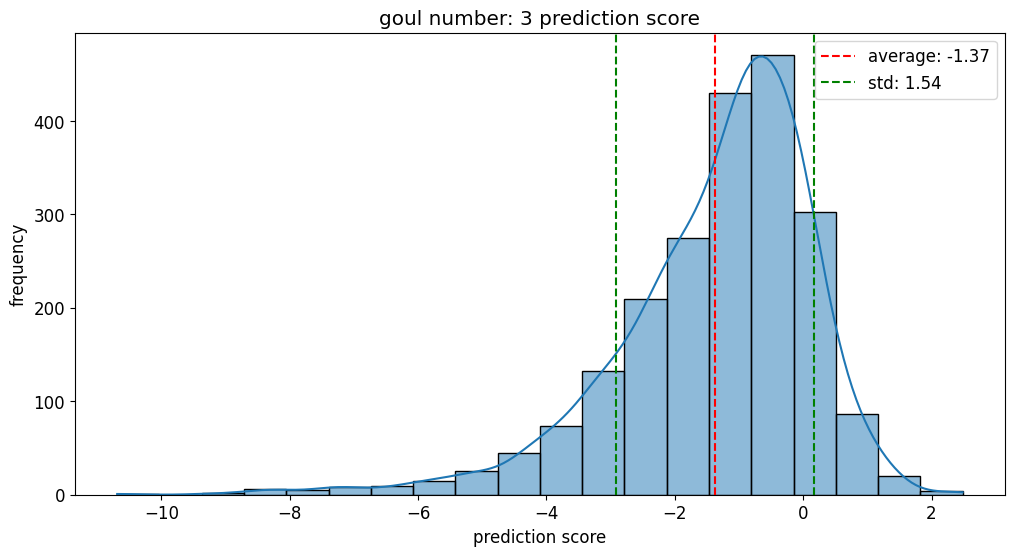

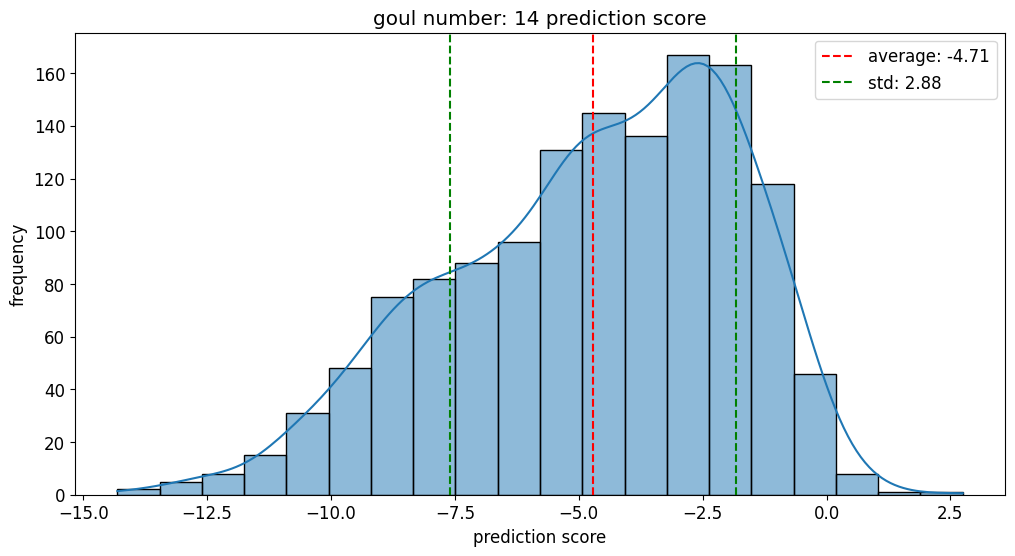

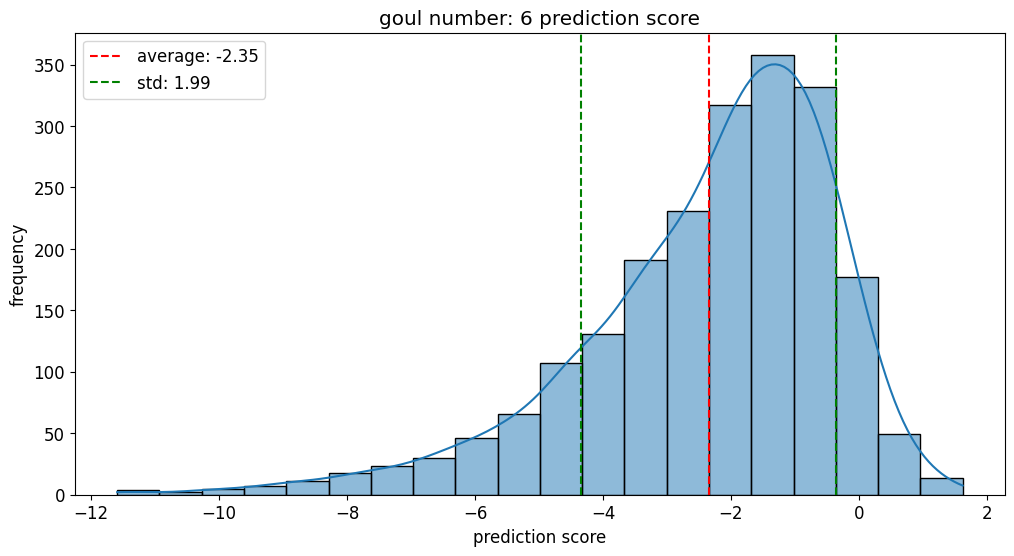

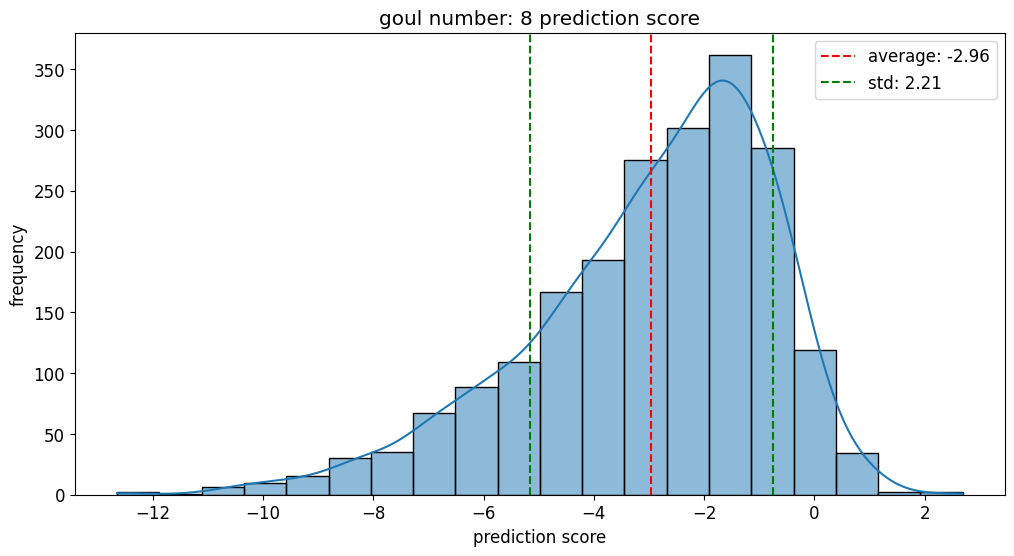

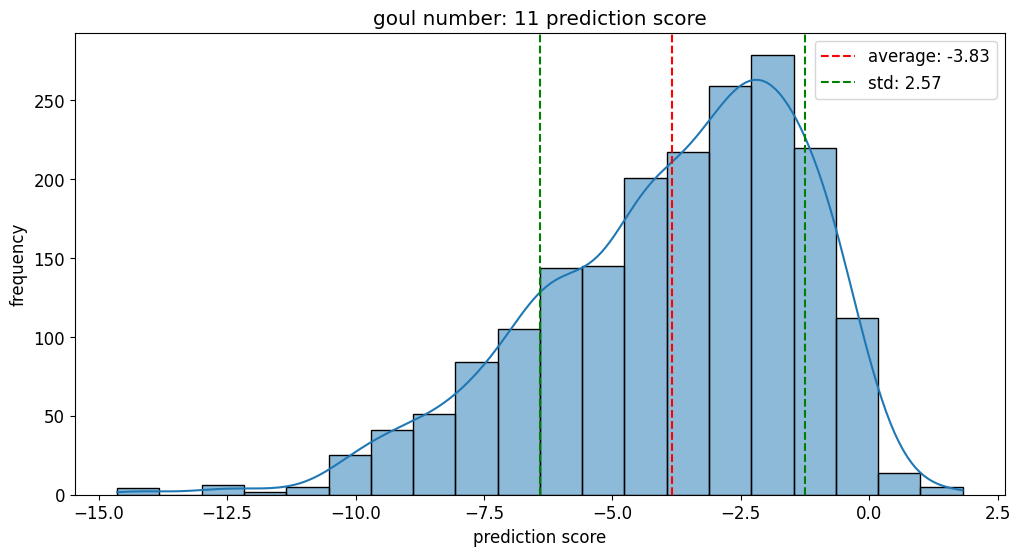

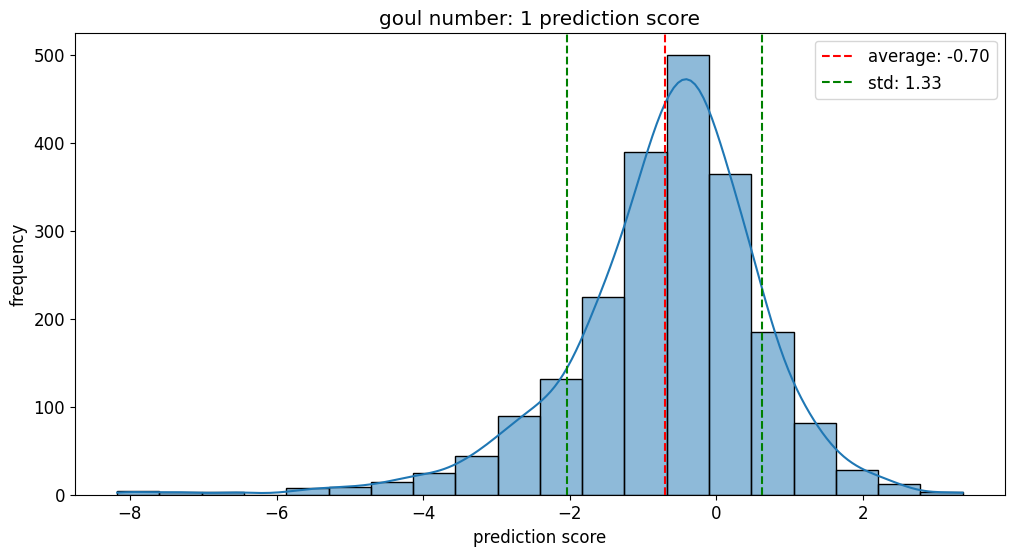

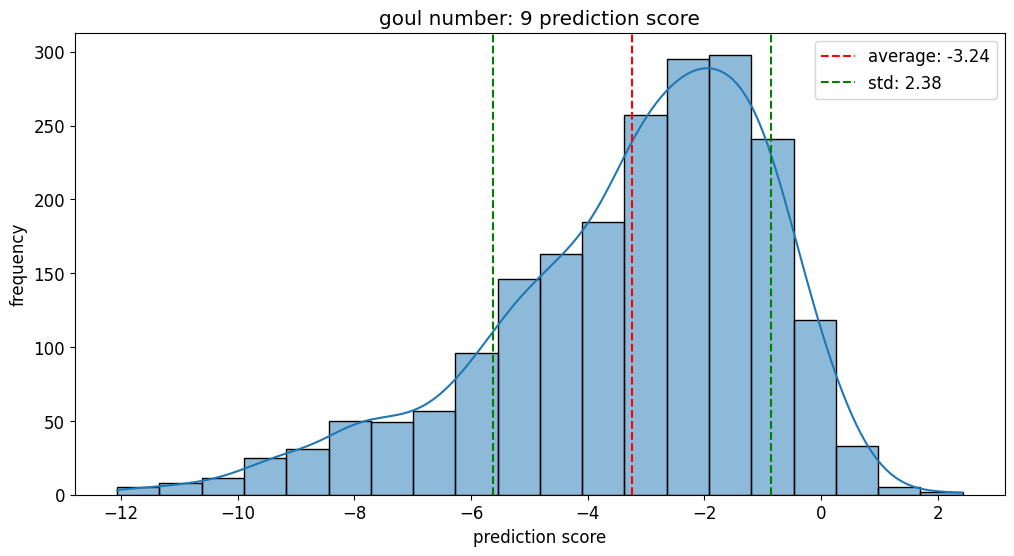

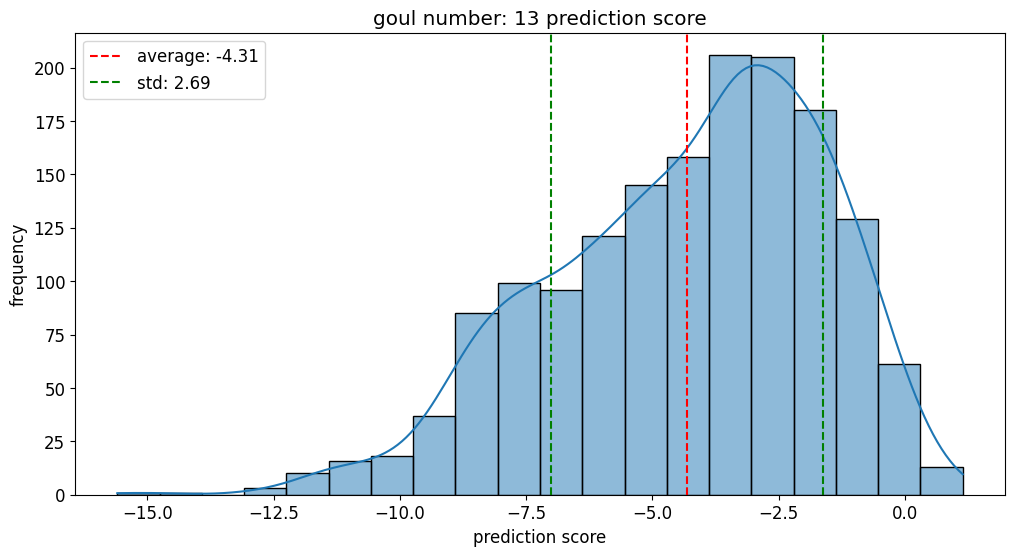

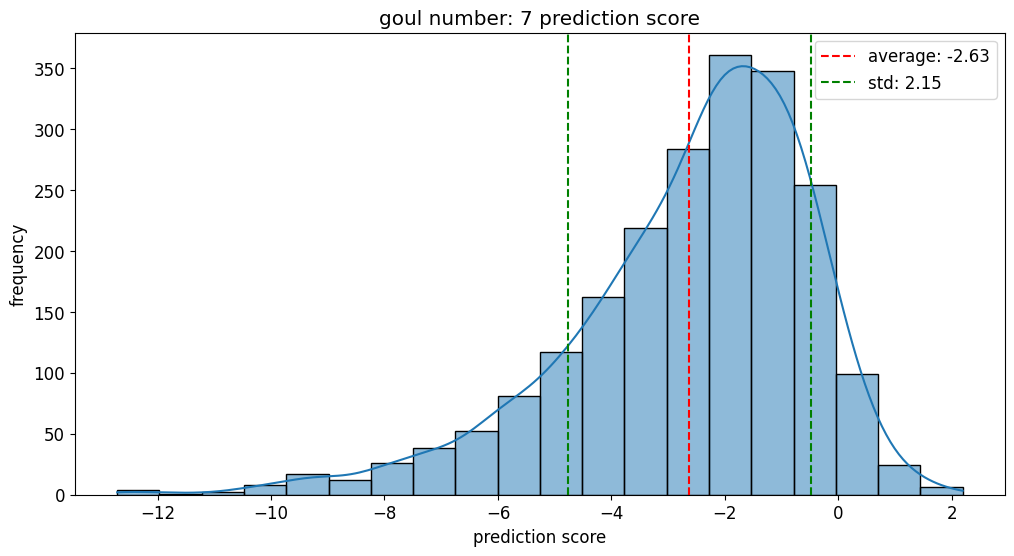

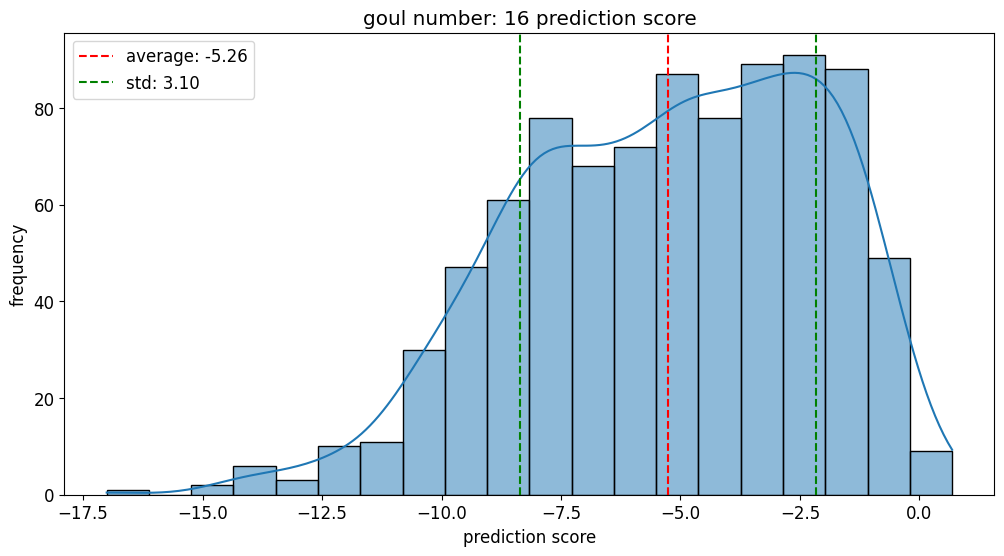

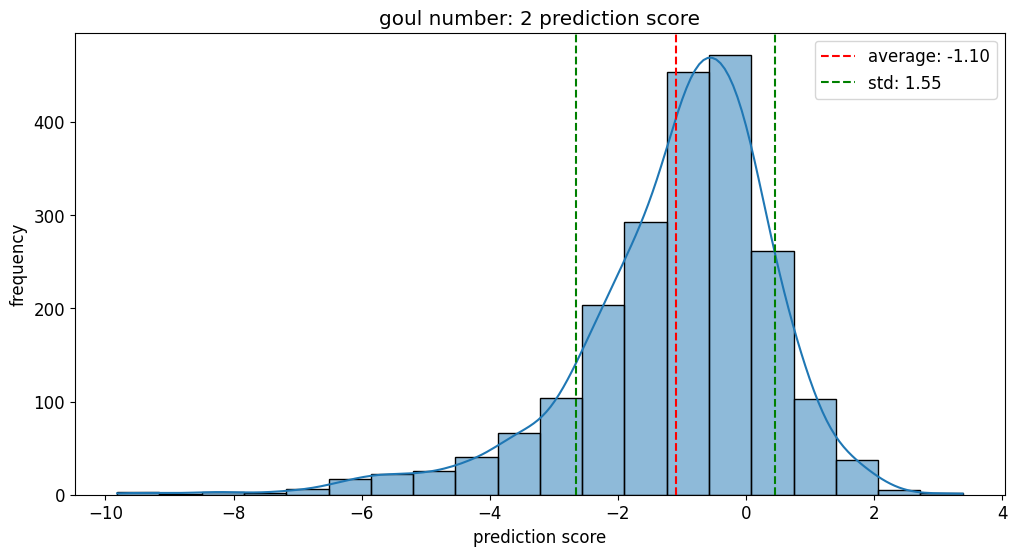

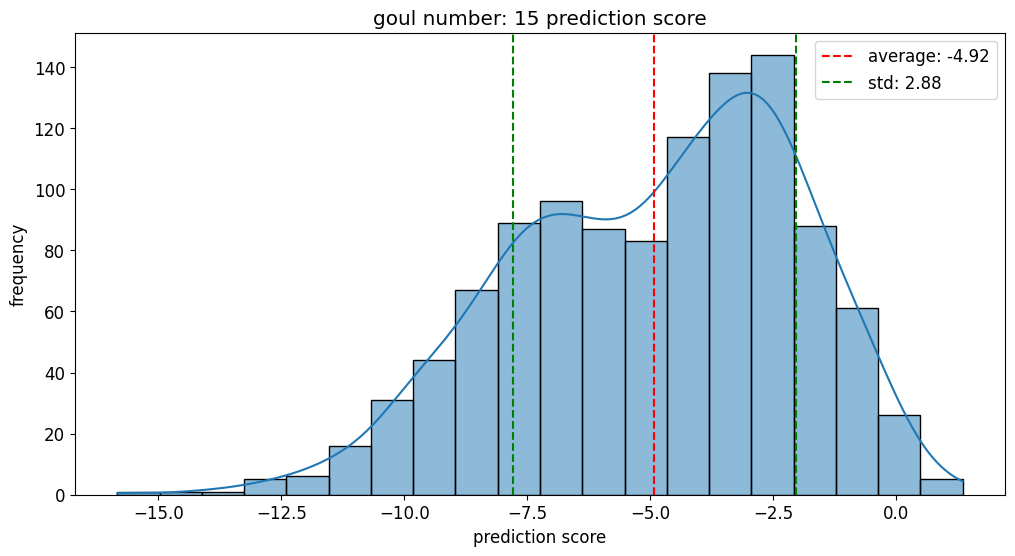

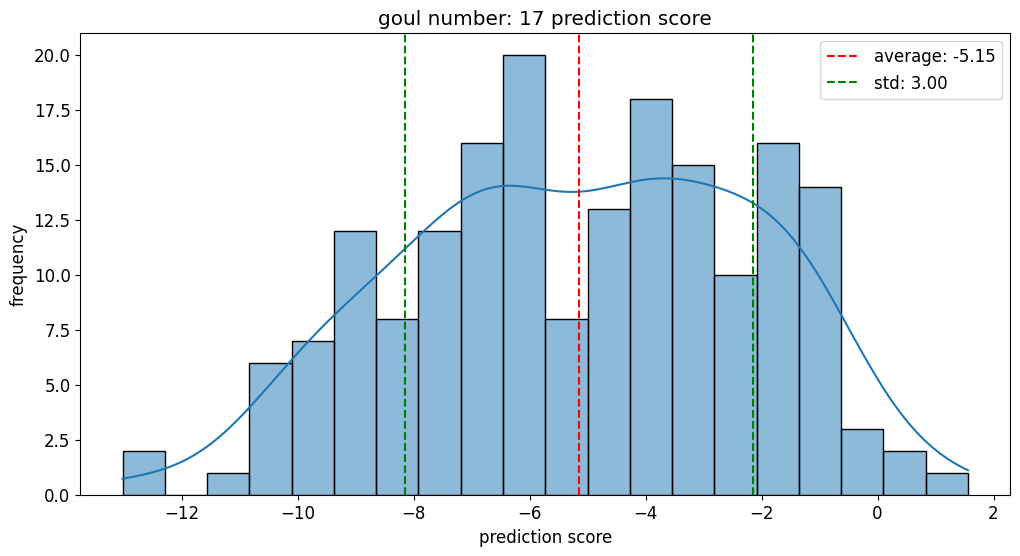

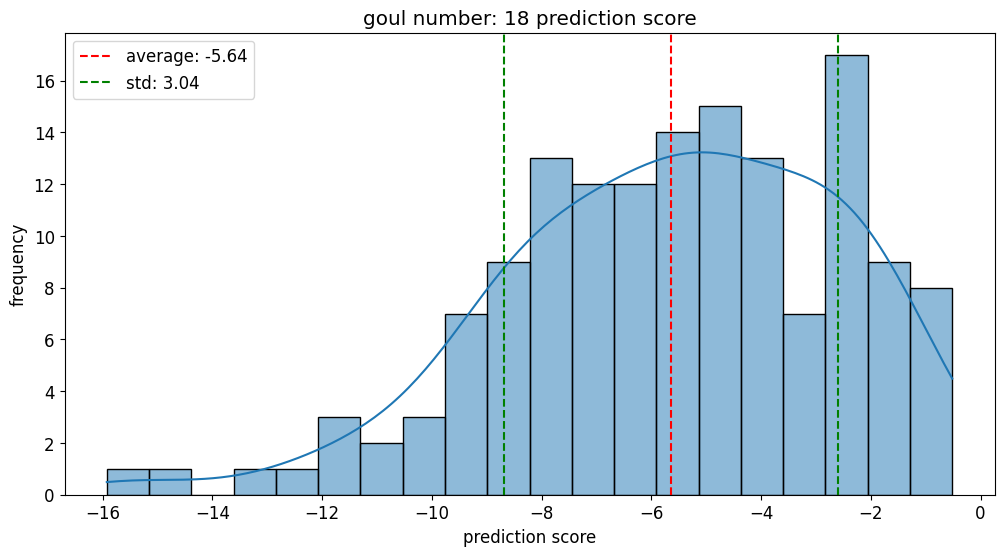

In [48]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# # 日本語フォントの設定
# font_path = '/usr/share/fonts/truetype/ipafont-gothic/ipagp.ttf'  # フォントのパス
# font_prop = fm.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = font_prop.get_name()

grouped = df_prediction_test_ranking.groupby("着順")["予測スコア"].agg(['mean', 'std']).reset_index()
unique_ranks = df_prediction_test_ranking["着順"].unique()

for rank in unique_ranks:
    plt.figure(figsize=(12, 6))
    subset = df_prediction_test_ranking[df_prediction_test_ranking["着順"] == rank]
    mean_score = subset["予測スコア"].mean()
    std_score = subset["予測スコア"].std()
    
    sns.histplot(subset["予測スコア"], bins=20, kde=True)
    plt.axvline(mean_score, color='r', linestyle='--', label=f'average: {mean_score:.2f}')
    plt.axvline(mean_score + std_score, color='g', linestyle='--', label=f'std: {std_score:.2f}')
    plt.axvline(mean_score - std_score, color='g', linestyle='--')
    
    plt.title(f"goul number: {rank} prediction score")
    plt.xlabel("prediction score")
    plt.ylabel("frequency")
    plt.legend()
    plt.show()

In [49]:
from pathlib import Path
import pandas as pd
import tqdm

# csvデータを1つずつ読み出し推論
p = Path(inference_data_path)
files = list(p.glob("inference*.csv"))
for file in tqdm.tqdm(files):
    # 読み込んだファイル名を出力
    print("=======予測ファイル名======== {}".format(file))
    inference_data = pd.read_csv(file, encoding='utf-8')
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する

    # object型の特長量を確認する
    object_columns = inference_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        inference_data[column] = le.fit_transform(inference_data[column])

    # Unnamed: 0,class_list_in_raceを削除
    inference_data = inference_data.drop(['Unnamed: 0',"class_list_in_race","date"], axis=1)
    # inference_data.info()

    #　=================real dataで推論=============================
    inference_data_answer = inference_data["goal_number"]
    inference_data = inference_data.drop("goal_number", axis=1)

    prediction_inference_ranking = best_model.predict(inference_data, num_iteration=best_model.best_iteration_)
    # データフレームを作成
    df_prediction_test_ranking = pd.DataFrame({
        "馬番号": inference_data["umaban"],
        "予測スコア": prediction_inference_ranking,
        "odds": inference_data["odds"],
        "着順": inference_data_answer,
    })

    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア", ascending=False)

    # 予測順位を計算
    df_prediction_test_ranking["予測順位"] = df_prediction_test_ranking["予測スコア"].rank(ascending=False, method='first').astype(int)

    # インデックスをリセット
    df_prediction_test_ranking = df_prediction_test_ranking.reset_index(drop=True)

    # 結果を確認
    # print(df_prediction_test_ranking.head())
    # pandasをcsvに保存
    # inference_data_path + /inference_resultにディレクトリを作成し、csvを保存する
    inference_data_path_result = inference_data_path + "inference_result/"
    if not os.path.isdir(inference_data_path_result):
        os.mkdir(inference_data_path_result)
    count = 0
    df_prediction_test_ranking.to_csv(inference_data_path_result + "prediction_real_data_inference_ranking_" +  str(count) + "_.csv", index=False)
    count +=1
    print(df_prediction_test_ranking)

100%|██████████| 7/7 [00:00<00:00, 44.52it/s]

=======予測ファイル名======== /home/hayato/horse_inference/inference/2024060508/add_dynamic_data/inference_data_202406050811.csv
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
    馬番号     予測スコア  着順  予測順位
0     6 -0.628846  14     1
1     5 -0.947114   7     2
2     7 -1.146883   1     3
3     3 -1.221555  12     4
4     8 -1.222133  13     5
5     4 -1.472400   4     6
6    10 -1.763086   5     7
7     2 -2.127557   6     8
8    13 -2.180460   9     9
9    12 -2.365097   8    10
10    9 -2.591966  11    11
11   14 -2.687918  15    12
12    1 -2.774743   3    13
13   11 -3.087073  10    14
14   15 -4.071349   2    15
=======予測ファイル名======== /home/hayato/horse_inference/inference/2024060508/add_dynamic_data/inference_data_20240605087.csv
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
    馬番号     予測スコア  着順  予測順位
0     3  0.046195   6     1
1     9 -

In [50]:
# やること
# 特長量前処理
# 特徴量追加
# ハイパラチューニング-> 完了
# 馬ID、ジョッキーIDを取得し、別csvで紐づけ